# 02 Daily Count Regression

Author: Harry Yau

Date: Aug 28, 2019

Packages that needs to be Installed:
- catboost

Warning, if you need re-run this script, please change the following parameter to 'CPU'.

In [19]:
CB_task = 'GPU'

In [2]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

import re
import seaborn as sns
import datetime
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

Load data.

- Station Data
- Cleaned data of bike trips
- Cleaned data of YVR weather data

In [3]:
data_folder = 'data'
pickle_folder = 'pickle'

#load station data
station_info_df = pd.read_csv(data_folder + '/' + 'station_data.csv', dtype={'id': str, 'name': str, 'lat': float, 'lon': float, 'total_slots':int})

def load_pickle(url):
    '''
    Function to load pickle file
    '''
    infile = open(url, 'rb')
    data = pickle.load(infile)
    infile.close()
    return data

filename = 'mobi_cleaned.pkl'
combined_df = load_pickle(pickle_folder + '/' + filename)

filename = 'YVR_wxdata.pkl'
weather_df = load_pickle(pickle_folder + '/' + filename)   

In [1]:
def average_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).sum()/target_df.resample(time_freq).count()
    
    return(output_target_df)


def max_df(colname, df, time_freq='D'):
    '''
    Function to calculate the maximum based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).max()
       
    return(output_target_df)


def min_df(colname, df, time_freq='D'):
    '''
    Function to calculate the minimum based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).min()

    return(output_target_df)


def sum_df(colname, df, time_freq='D'):
    '''
    Function to calculate the sum based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).sum()
    return(output_target_df)

##  Start of DF assembly

In [5]:
date_range_ind = pd.date_range(start=datetime.date(2017, 1, 1), end=datetime.date(2019, 3, 31), freq='D')

In [6]:
df = pd.DataFrame({'count': [1] * len(combined_df['Departure'])})
df.index = combined_df['Departure']

df = df.resample('D').count()
df = df[:-1]

var_list = ['CO', 'NO', 'NO2', 'O3', 'PM25', 'SO2', 'PM10', 'WSPD_SCLR',
       'WDIR_SCLR', 'WSPD_VECT', 'WDIR_VECT', 'TEMP_MEAN', 'ATM_PRESS_1HR',
       'HUMIDITY', 'RAD_TOTAL', 'PRECIP_TOTAL']

for var in var_list:
    df[('AVG_'+var)] = average_df(var, weather_df)

for var in ['TEMP_MEAN']:
    df[('MAX_'+var)] = max_df(var, weather_df)
    
for var in ['TEMP_MEAN']:
    df[('MIN_'+var)] = min_df(var, weather_df)

df['SUM_PRECIP_TOTAL'] = sum_df('PRECIP_TOTAL', weather_df)

### Plotting the Correlation Matrix

The data is first scaled before the correlation matrix was plotted, or else the results will be skewed.

The variables that are highly correlated to the daily trip counts are the average temperature and the average solar irradiance. There is a theoretical equation in which the total and average solar irradiance can be calcuated, but this variables fluctuates with cloud cover and aerosol concentration in the air. From a practical perspective, temperature and precipitation are the only variables where one can reasonable rely on if forecast data is to be used from a weather model. 

For this capstone project, the assumption will be made that the observed weather data used in the testing and validation data set as the same as the forecast data generated from a weather model. Usually, the data generated from a weather model are quite reliable for 2-3 days out.

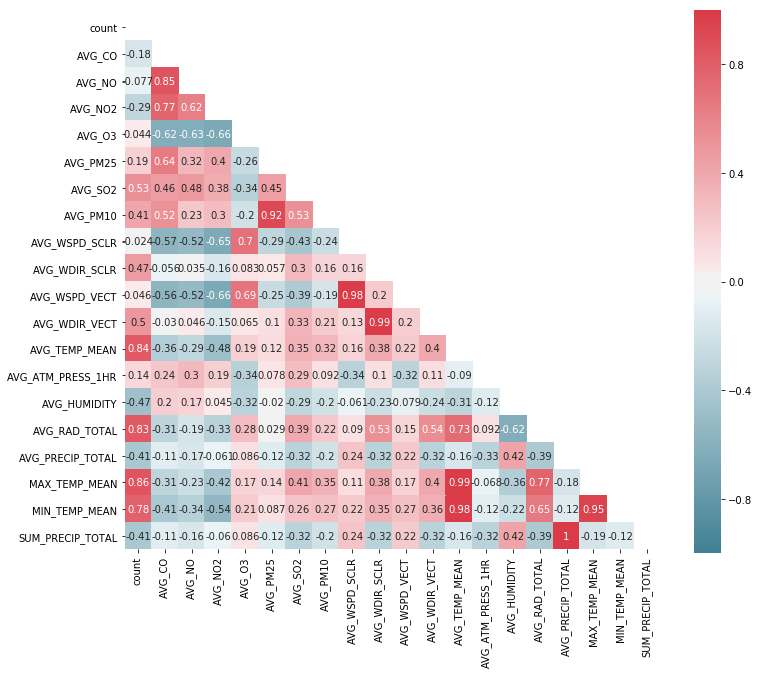

In [7]:
from sklearn.preprocessing import StandardScaler

def scale_data(df):
    scaler = StandardScaler()
    scaler.fit(df)
    scaled_df = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns, index=df.index)
    return(scaled_df)

#scaled_df = scale_data(df)

plt.figure(figsize=(12,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr_df = scale_data(df).corr()

mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_df, mask = mask, annot=True, cmap=cmap, center=0, vmin=-1.0, vmax=1.0, square=True);

The following is a chart of an overview of the dataset, and how the is split into Train, Validation and Test set.

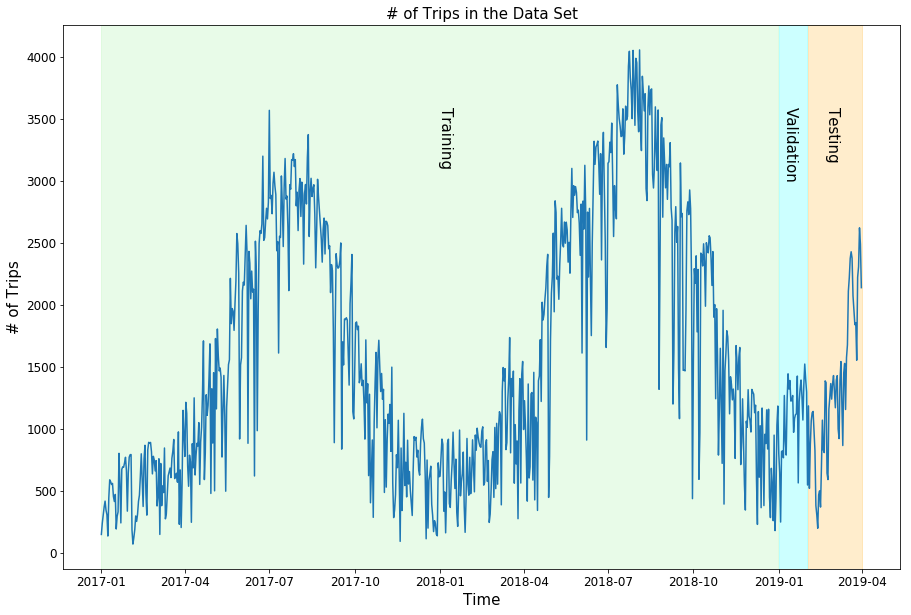

In [8]:
col = 'black'
a = 0.2
font_size_tick=12
plt.figure(figsize=(15,10))
plt.plot(df['count'], label='Count')
plt.xlabel('Time', fontsize=15, color=col)
plt.ylabel('# of Trips', fontsize=15, color=col)
plt.title('# of Trips in the Data Set',  fontsize=15, color=col)
plt.xticks(fontsize=font_size_tick, color=col)
plt.yticks(fontsize=font_size_tick, color=col)
plt.axvspan('2017-01-01', '2018-12-31', color='lightgreen', alpha=a)
plt.axvspan('2019-01-01', '2019-01-31', color='cyan', alpha=a)
plt.axvspan('2019-02-01', '2019-04-01', color='orange', alpha=a)
plt.annotate('Training', ('2017-12-30', 3500), fontsize=15, rotation=270)
plt.annotate('Validation', ('2019-01-05', 3500), fontsize=15, rotation=270)
plt.annotate('Testing', ('2019-02-20', 3500), fontsize=15, rotation=270)
plt.show();

### Adding Additional Features

#### Day of the Week

In [9]:
df['day_of_week']=df.index.to_series().dt.dayofweek

df.loc[df['day_of_week'] == 0, 'day_of_week'] = 'Monday'
df.loc[df['day_of_week'] == 1, 'day_of_week'] = 'Tuesday'
df.loc[df['day_of_week'] == 2, 'day_of_week'] = 'Wednesday'
df.loc[df['day_of_week'] == 3, 'day_of_week'] = 'Thursday'
df.loc[df['day_of_week'] == 4, 'day_of_week'] = 'Friday'
df.loc[df['day_of_week'] == 5, 'day_of_week'] = 'Saturday'
df.loc[df['day_of_week'] == 6, 'day_of_week'] = 'Sunday'

#### Holidays in BC

In [10]:
holiday_list = [datetime.datetime(2017, 1, 1),
    datetime.datetime(2017, 1, 2),
    datetime.datetime(2017, 2, 13),
    datetime.datetime(2017, 4, 14),
    datetime.datetime(2017, 5, 22),
    datetime.datetime(2017, 7, 1),
    datetime.datetime(2017, 8, 7),
    datetime.datetime(2017, 9, 4),
    datetime.datetime(2017, 10, 9),
    datetime.datetime(2017, 11, 10),
    datetime.datetime(2017, 11, 11),
    datetime.datetime(2017, 12, 24),
    datetime.datetime(2017, 12, 25),
    datetime.datetime(2017, 12, 26),
    datetime.datetime(2018, 1, 1),
    datetime.datetime(2018, 2, 12),
    datetime.datetime(2018, 3, 30),
    datetime.datetime(2018, 5, 21),
    datetime.datetime(2018, 7, 1),
    datetime.datetime(2018, 7, 2),
    datetime.datetime(2018, 8, 6),
    datetime.datetime(2018, 9, 3),
    datetime.datetime(2018, 10, 8),
    datetime.datetime(2018, 11, 11),
    datetime.datetime(2018, 11, 12),
    datetime.datetime(2018, 12, 24),
    datetime.datetime(2018, 12, 25),
    datetime.datetime(2018, 12, 26),
    datetime.datetime(2019, 1, 1),
    datetime.datetime(2019, 2, 18)
]
holiday_list = pd.to_datetime(holiday_list)

#convert to 1 and 0
holiday_col = date_range_ind.isin(holiday_list)

df['HOLIDAY'] = holiday_col.astype(int)
df['NOT_HOLIDAY'] = (~(holiday_col)).astype(int)

del holiday_list, holiday_col

#### Adding Season

In [11]:
#from stack overflow
#https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime

def season_of_date(date):
    year = str(date.year)
    seasons = {'Spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'Summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'Autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['Spring']:
        return 'Spring'
    if date in seasons['Summer']:
        return 'Summer'
    if date in seasons['Autumn']:
        return 'Autumn'
    else:
        return 'Winter'
    
df['SEASON'] = date_range_ind.map(season_of_date)

#### Add Quarter, Weekday, Weekend

In [12]:
df['QUARTER'] = date_range_ind.quarter.astype(str)

df['Weekday'] = df['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype(int)
df['Weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

#### Functions for model analysis 

In [13]:
def custom_predict(model, X_train, X_valid, X_test, y_scaler=None):
    '''
    Uses the predict method for a model on the train valid and test set.
    '''
    
    X_list = [X_train, X_valid, X_test]
    y_pred_list = []
    
    for i in range(0,3):
        
        y_pred = model.predict(X_list[i])
        
        #For Neural networks
        if y_scaler is not None:
            y_pred = y_scaler.inverse_transform(y_pred)
        
        y_pred_list.append(y_pred)
            
    return y_pred_list

def custom_model_score(y_pred_list, y_train, y_valid, y_test):
    '''
    Calculates the RMSE and R2 metrics
    '''
    
    import math
    from sklearn.metrics import r2_score, mean_squared_error
   
    score_output = [
        math.sqrt(mean_squared_error(y_train, y_pred_list[0].round())),
        math.sqrt(mean_squared_error(y_valid, y_pred_list[1].round())),
        math.sqrt(mean_squared_error(y_test, y_pred_list[2].round())),
        r2_score(y_train, y_pred_list[0].round()),
        r2_score(y_valid, y_pred_list[1].round()),
        r2_score(y_test, y_pred_list[2].round())
        ]
    
    return (score_output)

def custom_score_display(the_score, index=None):
    
    '''
    If a list of index is provided, it will expect the first argument to be a list to create a combined score.
    '''

    if index is None:
        output_score  = pd.DataFrame([the_score])
    else:
        output_score = pd.DataFrame(the_score)
        output_score.index = index
    
    output_score.columns = ['Training - RMSE', 'Validation - RMSE', 'Test - RMSE', 'Training - R2', 'Valid - R2', 'Test - R2']
    
    return (output_score)

def custom_plot_package(model_name, y_pred_list, y_train, y_valid, y_test):

    '''
    Outputs plots for train, valid, and test
    
    In addition, it calls the model_score function that calculates the RMSE and R2
    '''

    name_list = ['Training', 'Validation', 'Test']
    y_list = [y_train, y_valid, y_test]
    
    plt.figure(figsize=(12,12))
    for i in range(3):
        plt.subplot(3,1, (i + 1))
        plt.plot(y_list[i], label='Actual')
        plt.plot(pd.DataFrame(y_pred_list[i], index=y_list[i].index), label='Prediction')
        plt.legend()
        plt.title(model_name + ' - ' + name_list[i])
        plt.xlim(y_list[i].index[0], y_list[i].index[-1])
    plt.show();


def custom_tvt_split(Xy, date_range_train, date_range_valid, date_range_test):
    '''
    Wrapper function to split into train, valid, and test
    '''
    
    Xy_train = Xy.loc[date_range_train]
    Xy_test = Xy.loc[date_range_test]
    Xy_valid = Xy.loc[date_range_valid]
    
    return Xy_train, Xy_valid, Xy_test

### Assemble DataFrame

The features that will be used can be split into 2 categories. Weather and Time features.

Weather Features:
- Average Temperature - There is a higher correlation with the daily bike count due to seasonality.
- Max Temperature
- Min Temperature
- Sum of Precipitation - When this feature is included, it helps with accounting for the daily fluctuations.

Time Features:
- Day of the Week
- Holiday or Not a Holiday
- Season
- Quarter
- Weekday
- Weekend


In [14]:
X = df.reindex(['AVG_TEMP_MEAN', 'day_of_week', 'SUM_PRECIP_TOTAL', 'MAX_TEMP_MEAN', 'MIN_TEMP_MEAN',
                'HOLIDAY', 'NOT_HOLIDAY', 'SEASON', 'QUARTER', 'Weekday', 'Weekend'], axis=1)

y = df['count']

date_range_train = pd.date_range(start=datetime.date(2017, 1, 1), end=datetime.date(2018, 12, 31), freq='D')
date_range_valid = pd.date_range(start=datetime.date(2019, 1, 1), end=datetime.date(2019, 1, 31), freq='D')
date_range_test = pd.date_range(start=datetime.date(2019, 2, 1), end=datetime.date(2019, 3, 31), freq='D')

X_onehot = pd.get_dummies(X)
X_train, X_valid,  X_test = custom_tvt_split(X_onehot, date_range_train, date_range_valid, date_range_test)

y_train, y_valid,  y_test = custom_tvt_split(y, date_range_train, date_range_valid, date_range_test)

#For Statsmodel OLS
import statsmodels.api as sm
X_onehot_c = sm.add_constant(X_onehot)
X_train_c, X_valid_c,  X_test_c = custom_tvt_split(X_onehot_c, date_range_train, date_range_valid, date_range_test)

In [18]:
X_train.shape

(730, 23)

## Parameter Tuning

The parameter tuning was done by looping through the parameters and adjusting the parameters one at a time. The number of combinations to search through GridSearchCV was roughly 4.23 Million combinations, which wasn't feasible in utilizing given the time constraint considerations.

The error metric that will be used is the Root Mean Square Error (RMSE).  The RMSE is the standard deviation of the residuals and it is a measure of the spread of the residuals. The lower the RMSE, the better model results.

\begin{equation*}
RMSE = \sqrt{ (\hat{y} - y)^2 }
\end{equation*}

Please scroll to the bottom to 'Appendice 1 - Parameter Tuning' to view the Tuning steps.

## Model Comparison

The following regression models were investigated:
- Linear Regression
- Random Forest
- Gradient Boosting Methods:
    - XGBoost
    - CatBoost
- Neural Network

The range of models were chosen so that we can contrast models that ranged from simple to advanced techniques. The simple models are more easily interpretable, whereas a more advanced model is less interpretable. Overall, all the models under forecasted the daily number of bikes on the bike network. Only the linear model forecasted a negative bike total because the outputs are not constrained to only be positive. Analysing the RMSE outputs on the validation sets, XGBoost and CatBoost were the lowest two. For the test set, Random Forest and CatBoost were the lowest two, and XGBoost was a near third.

In [122]:
custom_score_display([lin_score, RF_score, XGB_score, CB_score, NN_score], 
                     index=['Linear Regression', 'Random Forest', 'XGBoost', 'CatBoost', 'Neural Network'])

Training - RMSE  Validation - RMSE  Test - RMSE  \
Linear Regression       404.757259         421.274793   558.745766   
Random Forest           182.186458         398.310140   486.551616   
XGBoost                 137.322997         367.306895   493.178673   
CatBoost                409.909467         279.206710   445.517182   
Neural Network          332.754076         457.639420   590.782747   

                   Training - R2  Valid - R2  Test - R2  
Linear Regression       0.846386   -1.003925   0.175153  
Random Forest           0.968878   -0.791403   0.374535  
XGBoost                 0.982318   -0.523381   0.357381  
CatBoost                0.842451    0.119758   0.475586  
Neural Network          0.896179   -1.364816   0.077852

For the charts and results of the individual models, please scroll down to 'Appendice 2 - Individual Model Ouputs'.

##  Composition Model

One combination appeared to be fairly robust after trying different combinations of prediction outputs from the models. This consisted of the average of: 2 times the output of XGBoost, 1 times the output of CatBoost and 1 times the output of a Neural Network.

\begin{equation*}
\hat{y}_{Composition Model} = \frac {2\hat{y}_{XGBoost} + \hat{y}_{CatBoost} + \hat{y}_{Neural Network}}{3}
\end{equation*}

The gradient boosting model XGBoost appeared to model the fluctuations fairly well in the validation and testing set. The results of XGBoost were multiplied by 2 to amplify these fluctuations. This lead to including a different gradient boosting method, CatBoost. The tuned CatBoost model appeared to follow the trend and fluctuations well. However, it wasn't accurate on predicting the values. This attribute was targeted to smooth out the effects of XGBoost after the 2 times amplication effect. Lastly, the predicted values of a Neural Network were included to give the composition model some stability in the outputs. 

The three different models that make up the composition model all have different characteristics.

- XGBoost: Captures the fluctuations well, but under forecasts the results.
- CatBoost: Follows the trend and fluctuations well, but not accurate in the value outputs
- Neural Network: Stable results that under forecasts the results. Addded to the composition model for stability.

In [123]:
def predict_composition_model(index_list):
    
    '''
    Best model average
    '''
    
    output_df = []
    
    for i in range(3):
        out_y_predictors = pd.DataFrame({
                                'XGBoost': XGB_y_pred_list[i]*2,
                                'CatBoost': CB_y_pred_list[i],
                                'Neural Network': NN_y_pred_list[i].reshape(1, NN_y_pred_list[i].shape[0])[0],
                                 })
        
        df_avg = pd.DataFrame({'Value': out_y_predictors.mean(axis=1)})
        df_avg.index = index_list[i]
        output_df.append(df_avg)
        
    return output_df

Training - RMSE  Validation - RMSE  Test - RMSE  Training - R2  Valid - R2  \
0       665.146822         195.695369   268.398578       0.585165    0.567574   

   Test - R2  
0   0.809671

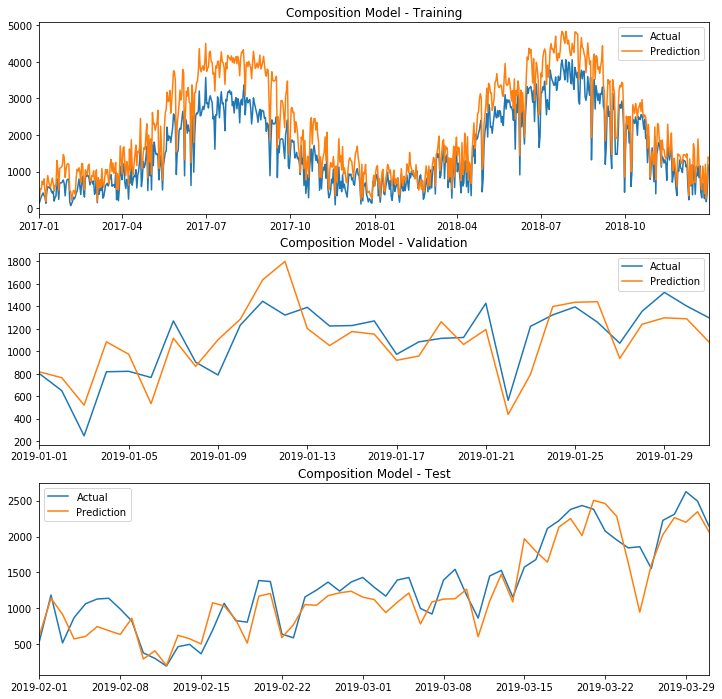

In [124]:
best_model_y_pred_list = predict_composition_model(index_list=[X_train.index, X_valid.index, X_test.index])
best_model_score = custom_model_score(best_model_y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(best_model_score))
custom_plot_package('Composition Model', best_model_y_pred_list, y_train, y_valid, y_test)

In [125]:
custom_score_display([lin_score, RF_score, XGB_score, CB_score, NN_score, best_model_score], 
                     index=['Linear Regression', 'Random Forest', 'XGBoost', 'CatBoost', 'Neural Network', 'Composition Model'])

Training - RMSE  Validation - RMSE  Test - RMSE  \
Linear Regression       404.757259         421.274793   558.745766   
Random Forest           182.186458         398.310140   486.551616   
XGBoost                 137.322997         367.306895   493.178673   
CatBoost                409.909467         279.206710   445.517182   
Neural Network          332.754076         457.639420   590.782747   
Composition Model       665.146822         195.695369   268.398578   

                   Training - R2  Valid - R2  Test - R2  
Linear Regression       0.846386   -1.003925   0.175153  
Random Forest           0.968878   -0.791403   0.374535  
XGBoost                 0.982318   -0.523381   0.357381  
CatBoost                0.842451    0.119758   0.475586  
Neural Network          0.896179   -1.364816   0.077852  
Composition Model       0.585165    0.567574   0.809671

## Backtesting the Model

A backtest of the model eror was done to test the stability of the model parameters. The models were trained with all available data immediately preceeding the 1 month test window where the RMSE value is recorded. The test set window was iterated through January 2018 to March 2019 for the predictions. eg. Predicted the bike count of January 2018 with a model trained with data from January to December 2017. The result is that the composition model was stable with low RMSE score throughout most of the iteration test period. Therefore there is value to further investigating in mixing and matching model outputs, which could lead to better results than just any one specific machine learning algorithm.

For the charts and results of the individual models, please scroll down to 'Appendice 3 - Backtesting Outputs'.

''

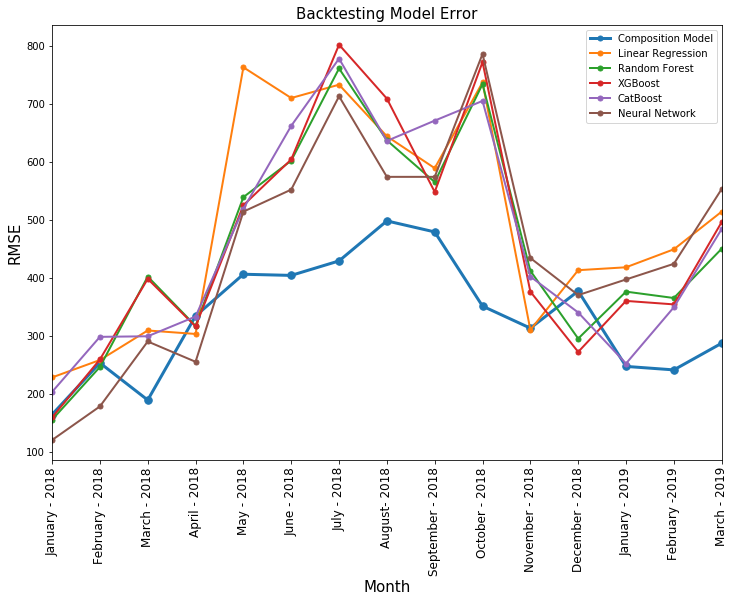

In [140]:
output = pd.concat(output_score, axis=1)
month_label = ['January - 2018', 'February - 2018', 'March - 2018', 'April - 2018', 'May - 2018', 'June - 2018', \
                  'July - 2018', 'August- 2018', 'September - 2018', 'October - 2018', 'November - 2018', 'December - 2018', \
                  'January - 2019', 'February -2019', 'March - 2019']

output.columns = month_label


font_size_tick = 12
ax = output.transpose().round().plot(figsize=(12,8), style='.-', markersize=10)
ax.set_xlabel('Month', size=15)
ax.set_ylabel('RMSE', size=15)
ax.set_title('Backtesting Model Error', size=15)
ax.set_xticks(range(0,len(month_label)), minor=False)
ax.set_xticklabels(month_label, fontsize=font_size_tick, rotation=90)
leg = ax.legend()


lws = [3] + [2]*6
mks = [15] + [10]*6
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=lws[i], markersize=mks[i])

for i, line in enumerate(leg.get_lines()):
    line.set_linewidth(lws[i])
    line.set_markersize(mks[i])
;

In [141]:
output.transpose().round()

Composition Model  Linear Regression  Random Forest  \
January - 2018                164.0              228.0          155.0   
February - 2018               253.0              258.0          246.0   
March - 2018                  189.0              309.0          402.0   
April - 2018                  334.0              303.0          317.0   
May - 2018                    406.0              763.0          539.0   
June - 2018                   404.0              710.0          602.0   
July - 2018                   429.0              733.0          761.0   
August- 2018                  498.0              644.0          637.0   
September - 2018              479.0              589.0          565.0   
October - 2018                351.0              737.0          734.0   
November - 2018               313.0              310.0          412.0   
December - 2018               377.0              413.0          295.0   
January - 2019                247.0              418.0          376.0   
February -2019                241.0              449.0          365.0   
March - 2019                  287.0              514.0          450.0   

                  XGBoost  CatBoost  Neural Network  
January - 2018      159.0     203.0           120.0  
February - 2018     259.0     298.0           178.0  
March - 2018        398.0     299.0           290.0  
April - 2018        316.0     333.0           255.0  
May - 2018          525.0     519.0           514.0  
June - 2018         604.0     662.0           552.0  
July - 2018         802.0     778.0           713.0  
August- 2018        709.0     636.0           574.0  
September - 2018    548.0     671.0           574.0  
October - 2018      772.0     705.0           786.0  
November - 2018     376.0     402.0           434.0  
December - 2018     272.0     340.0           370.0  
January - 2019      360.0     252.0           397.0  
February -2019      354.0     349.0           424.0  
March - 2019        496.0     484.0           553.0

## Appendice 1 - Parameter Tuning

### XGBoost Tuning

In [4]:
from xgboost import XGBRegressor

#####  XGBoost - Tuning the Depth: Fix Learning Rate and Number of Estimaters

3
[19:08:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4
[19:08:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5
[19:08:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6
[19:08:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
7
[19:08:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8
[19:08:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
9
[19:08:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Minimum RMSE for Validation, optimal depth:  4
Minimum RMSE for Testing, optimal depth:  4


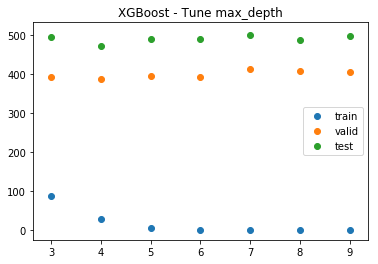

In [15]:
RMSE_train_list = []
RMSE_valid_list = []
RMSE_test_list = []

n_list = range(3,10,1)

for n in n_list:
    print(n)
       
    XGB_model = XGBRegressor(learning_rate=0.1, max_depth=n, 
                             n_estimators=1000, gamma=0, 
                             subsample=0.8, colsample_bytree=0.8,
                             scale_pos_weight=1, min_child_weight=1)
    
    XGB_model.fit(X_train, y_train)
    RMSE_train = math.sqrt(mean_squared_error(y_train, XGB_model.predict(X_train)))
    RMSE_valid = math.sqrt(mean_squared_error(y_valid, XGB_model.predict(X_valid)))
    RMSE_test = math.sqrt(mean_squared_error(y_test, XGB_model.predict(X_test)))
    
    RMSE_train_list.append(RMSE_train)
    RMSE_valid_list.append(RMSE_valid)
    RMSE_test_list.append(RMSE_test)
    
plt.scatter(n_list, RMSE_train_list, label='train')
plt.scatter(n_list, RMSE_valid_list, label='valid')
plt.scatter(n_list, RMSE_test_list, label='test')
plt.title('XGBoost - Tune max_depth')
plt.legend();

print()
print()
print('Minimum RMSE for Validation, optimal depth: ', n_list[np.argmin(RMSE_valid_list)])
print('Minimum RMSE for Testing, optimal depth: ',n_list[np.argmin(RMSE_test_list)])

##### XGBoost -  Tune min child weight

1
[19:08:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2
[19:08:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3
[19:08:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4
[19:08:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5
[19:08:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Minimum RMSE for Validation, optimal min_child_weight:  1
Minimum RMSE for Testing, optimal min_child_weight:  1


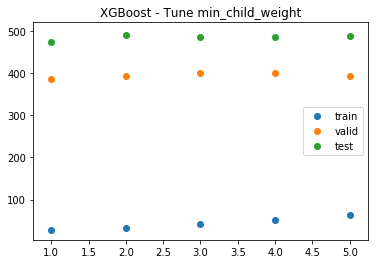

In [16]:
RMSE_train_list = []
RMSE_valid_list = []
RMSE_test_list = []

n_list = range(1,6,1)
for n in n_list:
    print(n)
       
    XGB_model = XGBRegressor(learning_rate=0.1, max_depth=4, 
                             n_estimators=1000, gamma=0, 
                             subsample=0.8, colsample_bytree=0.8,
                             scale_pos_weight=1, min_child_weight=n)
    
    XGB_model.fit(X_train, y_train)
    RMSE_train = math.sqrt(mean_squared_error(y_train, XGB_model.predict(X_train)))
    RMSE_valid = math.sqrt(mean_squared_error(y_valid, XGB_model.predict(X_valid)))
    RMSE_test = math.sqrt(mean_squared_error(y_test, XGB_model.predict(X_test)))
    
    RMSE_train_list.append(RMSE_train)
    RMSE_valid_list.append(RMSE_valid)
    RMSE_test_list.append(RMSE_test)
    
plt.scatter(n_list, RMSE_train_list, label='train')
plt.scatter(n_list, RMSE_valid_list, label='valid')
plt.scatter(n_list, RMSE_test_list, label='test')
plt.title('XGBoost - Tune min_child_weight')
plt.legend();

print()
print()
print('Minimum RMSE for Validation, optimal min_child_weight: ', n_list[np.argmin(RMSE_valid_list)])
print('Minimum RMSE for Testing, optimal min_child_weight: ',n_list[np.argmin(RMSE_test_list)])

##### XGBoost - Tune gamma

[19:08:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

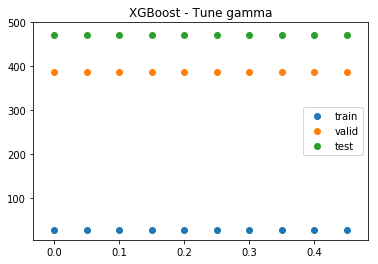

In [17]:
RMSE_train_list = []
RMSE_valid_list = []
RMSE_test_list = []

n_list = [i/10.0 for i in np.arange(0,5,0.5)]


for n in n_list:
    XGB_model = XGBRegressor(learning_rate=0.1, max_depth=4, 
                             n_estimators=1000, gamma=n, 
                             subsample=0.8, colsample_bytree=0.8,
                             scale_pos_weight=1, min_child_weight=1)
    
    XGB_model.fit(X_train, y_train)
    RMSE_train = math.sqrt(mean_squared_error(y_train, XGB_model.predict(X_train)))
    RMSE_valid = math.sqrt(mean_squared_error(y_valid, XGB_model.predict(X_valid)))
    RMSE_test = math.sqrt(mean_squared_error(y_test, XGB_model.predict(X_test)))
    
    RMSE_train_list.append(RMSE_train)
    RMSE_valid_list.append(RMSE_valid)
    RMSE_test_list.append(RMSE_test)
    
plt.scatter(n_list, RMSE_train_list, label='train')
plt.scatter(n_list, RMSE_valid_list, label='valid')
plt.scatter(n_list, RMSE_test_list, label='test')
plt.title('XGBoost - Tune gamma')
plt.legend();

print()
print()
print('Minimum RMSE for Validation, optimal gamma: ', n_list[np.argmin(RMSE_valid_list)])
print('Minimum RMSE for Testing, optimal gamma: ',n_list[np.argmin(RMSE_test_list)])

##### XGBoost - Tune subsample

[19:08:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Minimum RMSE for Validation, optimal subsample:  0.8
Minimum RMSE for Testing, optimal subsample:  0.8


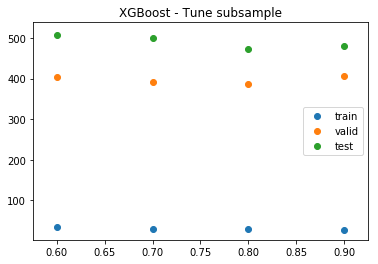

In [18]:
#Step 4 Tune subsample
RMSE_train_list = []
RMSE_valid_list = []
RMSE_test_list = []

n_list = [0.6,0.7,0.8,0.9]

for n in n_list:
    XGB_model = XGBRegressor(learning_rate=0.1, max_depth=4, 
                             n_estimators=1000, gamma=0, 
                             subsample=n, colsample_bytree=0.8,
                             scale_pos_weight=1, min_child_weight=1)
    XGB_model.fit(X_train, y_train)
    RMSE_train = math.sqrt(mean_squared_error(y_train, XGB_model.predict(X_train)))
    RMSE_valid = math.sqrt(mean_squared_error(y_valid, XGB_model.predict(X_valid)))
    RMSE_test = math.sqrt(mean_squared_error(y_test, XGB_model.predict(X_test)))
    
    RMSE_train_list.append(RMSE_train)
    RMSE_valid_list.append(RMSE_valid)
    RMSE_test_list.append(RMSE_test)
    
plt.scatter(n_list, RMSE_train_list, label='train')
plt.scatter(n_list, RMSE_valid_list, label='valid')
plt.scatter(n_list, RMSE_test_list, label='test')
plt.title('XGBoost - Tune subsample')
plt.legend();

print()
print()
print('Minimum RMSE for Validation, optimal subsample: ', n_list[np.argmin(RMSE_valid_list)])
print('Minimum RMSE for Testing, optimal subsample: ',n_list[np.argmin(RMSE_test_list)])

##### XGBoost - Tune colsample_bytree

[19:09:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Minimum RMSE for Validation, optimal colsample_bytree:  0.6
Minimum RMSE for Testing, optimal colsample_bytree:  0.8


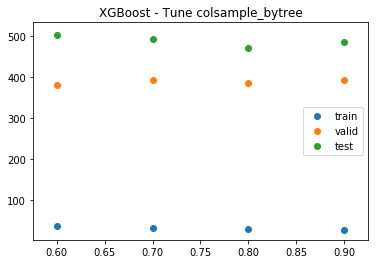

In [19]:
RMSE_train_list = []
RMSE_valid_list = []
RMSE_test_list = []

n_list = [0.6,0.7,0.8,0.9]

for n in n_list:
    XGB_model = XGBRegressor(learning_rate=0.1, max_depth=4, 
                             n_estimators=1000, gamma=0, 
                             subsample=0.8, colsample_bytree=n,
                             scale_pos_weight=1, min_child_weight=1)
    
    XGB_model.fit(X_train, y_train)
    RMSE_train = math.sqrt(mean_squared_error(y_train, XGB_model.predict(X_train)))
    RMSE_valid = math.sqrt(mean_squared_error(y_valid, XGB_model.predict(X_valid)))
    RMSE_test = math.sqrt(mean_squared_error(y_test, XGB_model.predict(X_test)))
    
    RMSE_train_list.append(RMSE_train)
    RMSE_valid_list.append(RMSE_valid)
    RMSE_test_list.append(RMSE_test)
    
plt.scatter(n_list, RMSE_train_list, label='train')
plt.scatter(n_list, RMSE_valid_list, label='valid')
plt.scatter(n_list, RMSE_test_list, label='test')
plt.title('XGBoost - Tune colsample_bytree')
plt.legend();

print()
print()
print('Minimum RMSE for Validation, optimal colsample_bytree: ', n_list[np.argmin(RMSE_valid_list)])
print('Minimum RMSE for Testing, optimal colsample_bytree: ',n_list[np.argmin(RMSE_test_list)])

##### XGBoost - Tune alpha regularization

[19:09:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Minimum RMSE for Validation, optimal reg_alpha:  1
Minimum RMSE for Te

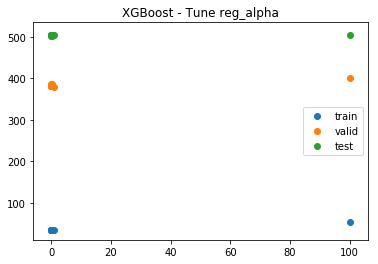

In [20]:
RMSE_train_list = []
RMSE_valid_list = []
RMSE_test_list = []

n_list = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 100]

for n in n_list:
    XGB_model = XGBRegressor(learning_rate=0.1, max_depth=4, 
                             n_estimators=1000, gamma=0, 
                             subsample=0.8, colsample_bytree=0.6,
                             scale_pos_weight=1, min_child_weight=1,
                             reg_alpha=n)
    XGB_model.fit(X_train, y_train)
    RMSE_train = math.sqrt(mean_squared_error(y_train, XGB_model.predict(X_train)))
    RMSE_valid = math.sqrt(mean_squared_error(y_valid, XGB_model.predict(X_valid)))
    RMSE_test = math.sqrt(mean_squared_error(y_test, XGB_model.predict(X_test)))
    
    RMSE_train_list.append(RMSE_train)
    RMSE_valid_list.append(RMSE_valid)
    RMSE_test_list.append(RMSE_test)
    
plt.scatter(n_list, RMSE_train_list, label='train')
plt.scatter(n_list, RMSE_valid_list, label='valid')
plt.scatter(n_list, RMSE_test_list, label='test')
plt.title('XGBoost - Tune reg_alpha')
plt.legend();

print()
print()
print('Minimum RMSE for Validation, optimal reg_alpha: ', n_list[np.argmin(RMSE_valid_list)])
print('Minimum RMSE for Testing, optimal reg_alpha: ',n_list[np.argmin(RMSE_test_list)])

##### XGBoost - Tune Step Learning Rate

[19:09:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:10:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:10:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:10:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Minimum RMSE for Validation, optimal learning_rate:  0.05
Minimum RMSE for Testing, optimal learning_rate:  0.05


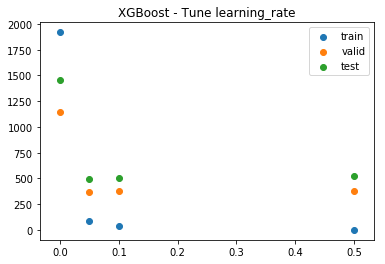

In [21]:
#Step learning rate
RMSE_train_list = []
RMSE_valid_list = []
RMSE_test_list = []

n_list = [0, 0.05, 0.1,0.5]

for n in n_list:
    XGB_model = XGBRegressor(learning_rate=n, max_depth=4, 
                             n_estimators=1000, gamma=0, 
                             subsample=0.8, colsample_bytree=0.6,
                             scale_pos_weight=1, min_child_weight=1,
                             reg_alpha=1)
    
    XGB_model.fit(X_train, y_train)
    RMSE_train = math.sqrt(mean_squared_error(y_train, XGB_model.predict(X_train)))
    RMSE_valid = math.sqrt(mean_squared_error(y_valid, XGB_model.predict(X_valid)))
    RMSE_test = math.sqrt(mean_squared_error(y_test, XGB_model.predict(X_test)))
    
    RMSE_train_list.append(RMSE_train)
    RMSE_valid_list.append(RMSE_valid)
    RMSE_test_list.append(RMSE_test)
    
plt.scatter(n_list, RMSE_train_list, label='train')
plt.scatter(n_list, RMSE_valid_list, label='valid')
plt.scatter(n_list, RMSE_test_list, label='test')
plt.title('XGBoost - Tune learning_rate')
plt.legend();

print()
print()
print('Minimum RMSE for Validation, optimal learning_rate: ', n_list[np.argmin(RMSE_valid_list)])
print('Minimum RMSE for Testing, optimal learning_rate: ',n_list[np.argmin(RMSE_test_list)])

##### XGBoost - Tune estimator

[19:10:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:10:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:10:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:10:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:10:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:10:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:10:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:10:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:10:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

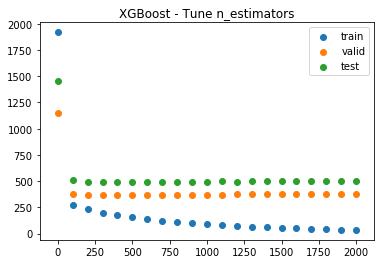

In [22]:
#Step estimator
RMSE_train_list = []
RMSE_valid_list = []
RMSE_test_list = []

n_list = range(0,2100,100)

for n in n_list:
    XGB_model = XGBRegressor(learning_rate=0.05, max_depth=4, 
                             n_estimators=n, gamma=0, 
                             subsample=0.8, colsample_bytree=0.6,
                             scale_pos_weight=1, min_child_weight=1,
                             reg_alpha=1)
    
    XGB_model.fit(X_train, y_train)
    RMSE_train = math.sqrt(mean_squared_error(y_train, XGB_model.predict(X_train)))
    RMSE_valid = math.sqrt(mean_squared_error(y_valid, XGB_model.predict(X_valid)))
    RMSE_test = math.sqrt(mean_squared_error(y_test, XGB_model.predict(X_test)))
    
    RMSE_train_list.append(RMSE_train)
    RMSE_valid_list.append(RMSE_valid)
    RMSE_test_list.append(RMSE_test)
    
plt.scatter(n_list, RMSE_train_list, label='train')
plt.scatter(n_list, RMSE_valid_list, label='valid')
plt.scatter(n_list, RMSE_test_list, label='test')
plt.title('XGBoost - Tune n_estimators')
plt.legend();

print()
print()
print('Minimum RMSE for Validation, optimal n_estimators: ', n_list[np.argmin(RMSE_valid_list)])
print('Minimum RMSE for Testing, optimal n_estimators: ',n_list[np.argmin(RMSE_test_list)])

##### XGBoost - Best Model Parameters

In [23]:
XGB_model = XGBRegressor(learning_rate=0.05, max_depth=4, 
                         n_estimators=600, gamma=0, 
                         subsample=0.8, colsample_bytree=0.6,
                         scale_pos_weight=1, min_child_weight=1,
                         reg_alpha=1)

### Tuning CatBoost

In [ ]:
from catboost import CatBoostRegressor

##### CatBoost - Tune max_depth

0:	learn: 1748.3401569	total: 9.8ms	remaining: 9.79s
1:	learn: 1589.1723494	total: 18.7ms	remaining: 9.34s
2:	learn: 1446.8440099	total: 27.7ms	remaining: 9.2s
3:	learn: 1321.0291380	total: 36.4ms	remaining: 9.06s
4:	learn: 1206.6397494	total: 45.8ms	remaining: 9.11s
5:	learn: 1105.2405577	total: 54.5ms	remaining: 9.03s
6:	learn: 1011.5278990	total: 64.4ms	remaining: 9.13s
7:	learn: 931.1260527	total: 75.9ms	remaining: 9.41s
8:	learn: 856.7729963	total: 88.2ms	remaining: 9.71s
9:	learn: 792.3414236	total: 98.6ms	remaining: 9.77s
10:	learn: 736.4286423	total: 109ms	remaining: 9.81s
11:	learn: 687.3292366	total: 119ms	remaining: 9.82s
12:	learn: 641.1973389	total: 131ms	remaining: 9.91s
13:	learn: 601.0732319	total: 139ms	remaining: 9.79s
14:	learn: 567.9109519	total: 148ms	remaining: 9.74s
15:	learn: 538.2055828	total: 157ms	remaining: 9.69s
16:	learn: 514.5532229	total: 168ms	remaining: 9.71s
17:	learn: 491.4599553	total: 178ms	remaining: 9.72s
18:	learn: 472.9589516	total: 188ms	remai

160:	learn: 326.0740818	total: 2.04s	remaining: 10.6s
161:	learn: 326.0739642	total: 2.05s	remaining: 10.6s
162:	learn: 325.6612409	total: 2.06s	remaining: 10.6s
163:	learn: 325.3110293	total: 2.07s	remaining: 10.5s
164:	learn: 325.2406317	total: 2.08s	remaining: 10.5s
165:	learn: 324.9532401	total: 2.09s	remaining: 10.5s
166:	learn: 324.7042574	total: 2.1s	remaining: 10.5s
167:	learn: 324.6485645	total: 2.1s	remaining: 10.4s
168:	learn: 324.5995805	total: 2.12s	remaining: 10.4s
169:	learn: 324.3913078	total: 2.13s	remaining: 10.4s
170:	learn: 324.3910375	total: 2.13s	remaining: 10.3s
171:	learn: 324.1873972	total: 2.14s	remaining: 10.3s
172:	learn: 324.0114322	total: 2.15s	remaining: 10.3s
173:	learn: 323.7948446	total: 2.16s	remaining: 10.3s
174:	learn: 323.7942692	total: 2.17s	remaining: 10.2s
175:	learn: 323.6141453	total: 2.18s	remaining: 10.2s
176:	learn: 323.6135697	total: 2.19s	remaining: 10.2s
177:	learn: 323.6130617	total: 2.21s	remaining: 10.2s
178:	learn: 323.4326675	total:

313:	learn: 317.2383918	total: 3.68s	remaining: 8.04s
314:	learn: 317.2383228	total: 3.69s	remaining: 8.02s
315:	learn: 317.2382882	total: 3.7s	remaining: 8.01s
316:	learn: 317.2382537	total: 3.71s	remaining: 7.99s
317:	learn: 317.2382191	total: 3.71s	remaining: 7.97s
318:	learn: 317.2382018	total: 3.73s	remaining: 7.95s
319:	learn: 317.2381846	total: 3.73s	remaining: 7.93s
320:	learn: 317.2381500	total: 3.74s	remaining: 7.92s
321:	learn: 317.2381328	total: 3.75s	remaining: 7.9s
322:	learn: 317.2381155	total: 3.76s	remaining: 7.88s
323:	learn: 317.2380982	total: 3.77s	remaining: 7.86s
324:	learn: 317.2380809	total: 3.78s	remaining: 7.84s
325:	learn: 317.2380809	total: 3.79s	remaining: 7.83s
326:	learn: 317.2380637	total: 3.79s	remaining: 7.81s
327:	learn: 317.2380464	total: 3.8s	remaining: 7.79s
328:	learn: 317.2380464	total: 3.81s	remaining: 7.78s
329:	learn: 317.2380464	total: 3.82s	remaining: 7.76s
330:	learn: 317.2243664	total: 3.83s	remaining: 7.74s
331:	learn: 317.2243491	total: 

477:	learn: 306.8820129	total: 5.36s	remaining: 5.85s
478:	learn: 306.8779955	total: 5.37s	remaining: 5.84s
479:	learn: 306.8262995	total: 5.38s	remaining: 5.83s
480:	learn: 306.7325639	total: 5.39s	remaining: 5.81s
481:	learn: 306.7322602	total: 5.4s	remaining: 5.8s
482:	learn: 306.7091970	total: 5.41s	remaining: 5.79s
483:	learn: 306.7064457	total: 5.42s	remaining: 5.78s
484:	learn: 306.7022294	total: 5.43s	remaining: 5.77s
485:	learn: 306.6980667	total: 5.45s	remaining: 5.76s
486:	learn: 306.4304073	total: 5.46s	remaining: 5.75s
487:	learn: 306.4240593	total: 5.47s	remaining: 5.74s
488:	learn: 306.3790293	total: 5.48s	remaining: 5.73s
489:	learn: 306.3638270	total: 5.49s	remaining: 5.71s
490:	learn: 306.2849242	total: 5.5s	remaining: 5.7s
491:	learn: 306.1893228	total: 5.51s	remaining: 5.69s
492:	learn: 305.9499108	total: 5.52s	remaining: 5.68s
493:	learn: 305.9095040	total: 5.53s	remaining: 5.67s
494:	learn: 305.9071576	total: 5.54s	remaining: 5.65s
495:	learn: 305.8852323	total: 5

637:	learn: 300.7373405	total: 7.19s	remaining: 4.08s
638:	learn: 300.7371036	total: 7.21s	remaining: 4.07s
639:	learn: 300.7364750	total: 7.22s	remaining: 4.06s
640:	learn: 300.7359102	total: 7.24s	remaining: 4.05s
641:	learn: 300.2844496	total: 7.25s	remaining: 4.04s
642:	learn: 300.2842945	total: 7.26s	remaining: 4.03s
643:	learn: 300.2840664	total: 7.27s	remaining: 4.02s
644:	learn: 300.2838748	total: 7.29s	remaining: 4.01s
645:	learn: 300.2837380	total: 7.3s	remaining: 4s
646:	learn: 300.1592454	total: 7.31s	remaining: 3.99s
647:	learn: 300.1591724	total: 7.32s	remaining: 3.98s
648:	learn: 300.1586978	total: 7.33s	remaining: 3.97s
649:	learn: 300.1585700	total: 7.35s	remaining: 3.96s
650:	learn: 300.1555578	total: 7.36s	remaining: 3.94s
651:	learn: 300.1554574	total: 7.37s	remaining: 3.93s
652:	learn: 300.1550741	total: 7.38s	remaining: 3.92s
653:	learn: 300.1525822	total: 7.39s	remaining: 3.91s
654:	learn: 300.1522810	total: 7.41s	remaining: 3.9s
655:	learn: 300.1019005	total: 7.

800:	learn: 294.5253995	total: 9.05s	remaining: 2.25s
801:	learn: 294.5253995	total: 9.06s	remaining: 2.24s
802:	learn: 294.5254088	total: 9.08s	remaining: 2.23s
803:	learn: 294.5251111	total: 9.09s	remaining: 2.21s
804:	learn: 294.5207019	total: 9.1s	remaining: 2.2s
805:	learn: 294.5207019	total: 9.11s	remaining: 2.19s
806:	learn: 294.5206926	total: 9.11s	remaining: 2.18s
807:	learn: 294.5206926	total: 9.13s	remaining: 2.17s
808:	learn: 294.5085714	total: 9.13s	remaining: 2.16s
809:	learn: 294.5085714	total: 9.14s	remaining: 2.15s
810:	learn: 294.4942821	total: 9.16s	remaining: 2.13s
811:	learn: 294.3707661	total: 9.18s	remaining: 2.13s
812:	learn: 294.0303591	total: 9.21s	remaining: 2.12s
813:	learn: 294.0303404	total: 9.24s	remaining: 2.11s
814:	learn: 294.0303404	total: 9.26s	remaining: 2.1s
815:	learn: 294.0295950	total: 9.27s	remaining: 2.09s
816:	learn: 294.0258306	total: 9.28s	remaining: 2.08s
817:	learn: 293.7800874	total: 9.29s	remaining: 2.07s
818:	learn: 293.7800687	total: 

961:	learn: 289.0254764	total: 11s	remaining: 436ms
962:	learn: 289.0230118	total: 11.1s	remaining: 425ms
963:	learn: 289.0230118	total: 11.1s	remaining: 414ms
964:	learn: 289.0227085	total: 11.1s	remaining: 402ms
965:	learn: 289.0226990	total: 11.1s	remaining: 391ms
966:	learn: 288.9442094	total: 11.1s	remaining: 379ms
967:	learn: 288.9361213	total: 11.1s	remaining: 368ms
968:	learn: 288.7175802	total: 11.1s	remaining: 356ms
969:	learn: 288.7134238	total: 11.1s	remaining: 345ms
970:	learn: 288.7131771	total: 11.2s	remaining: 333ms
971:	learn: 288.7131771	total: 11.2s	remaining: 322ms
972:	learn: 288.5453361	total: 11.2s	remaining: 310ms
973:	learn: 288.3848171	total: 11.2s	remaining: 299ms
974:	learn: 288.3398585	total: 11.2s	remaining: 287ms
975:	learn: 288.3396019	total: 11.2s	remaining: 276ms
976:	learn: 288.3389368	total: 11.2s	remaining: 264ms
977:	learn: 288.3386137	total: 11.2s	remaining: 253ms
978:	learn: 288.3382146	total: 11.3s	remaining: 241ms
979:	learn: 288.3316583	total:

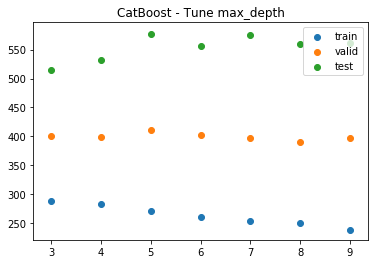

In [27]:
RMSE_train_list = []
RMSE_valid_list = []
RMSE_test_list = []

n_list = range(3,10,1)

for n in n_list:
    print(n)    
    CB_model = CatBoostRegressor(learning_rate=0.1, 
                                 max_depth=n, 
                                 n_estimators=1000, 
                                 l2_leaf_reg=3.0,
                                 random_strength=1,
                                 bagging_temperature=1,
                                 task_type=CB_task)
    
    CB_model.fit(X_train, y_train, verbose=0)
    RMSE_train = math.sqrt(mean_squared_error(y_train, CB_model.predict(X_train)))
    RMSE_valid = math.sqrt(mean_squared_error(y_valid, CB_model.predict(X_valid)))
    RMSE_test = math.sqrt(mean_squared_error(y_test, CB_model.predict(X_test)))
    
    RMSE_train_list.append(RMSE_train)
    RMSE_valid_list.append(RMSE_valid)
    RMSE_test_list.append(RMSE_test)
    
plt.scatter(n_list, RMSE_train_list, label='train')
plt.scatter(n_list, RMSE_valid_list, label='valid')
plt.scatter(n_list, RMSE_test_list, label='test')
plt.title('CatBoost - Tune max_depth')
plt.legend();

print()
print()
print('Minimum RMSE for Validation, optimal depth: ', n_list[np.argmin(RMSE_valid_list)])
print('Minimum RMSE for Testing, optimal depth: ',n_list[np.argmin(RMSE_test_list)])

##### CatBoost - Tune l2_leaf_reg

0
0.1
0.5
1
2
3
4
5
6


Minimum RMSE for Validation, optimal l2_leaf_reg:  6
Minimum RMSE for Testing, optimal l2_leaf_reg:  3


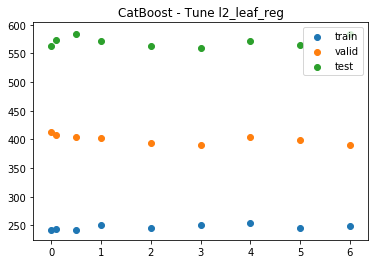

In [28]:
RMSE_train_list = []
RMSE_valid_list = []
RMSE_test_list = []

n_list = [0, 0.1, 0.5, 1, 2, 3, 4, 5, 6]

for n in n_list:
    print(n)    
    CB_model = CatBoostRegressor(learning_rate=0.1, 
                                 max_depth=8, 
                                 n_estimators=1000, 
                                 l2_leaf_reg=n,
                                 random_strength=1,
                                 bagging_temperature=1,
                                 task_type='GPU')
    
    CB_model.fit(X_train, y_train, verbose=0)
    RMSE_train = math.sqrt(mean_squared_error(y_train, CB_model.predict(X_train)))
    RMSE_valid = math.sqrt(mean_squared_error(y_valid, CB_model.predict(X_valid)))
    RMSE_test = math.sqrt(mean_squared_error(y_test, CB_model.predict(X_test)))
    
    RMSE_train_list.append(RMSE_train)
    RMSE_valid_list.append(RMSE_valid)
    RMSE_test_list.append(RMSE_test)
    
plt.scatter(n_list, RMSE_train_list, label='train')
plt.scatter(n_list, RMSE_valid_list, label='valid')
plt.scatter(n_list, RMSE_test_list, label='test')
plt.title('CatBoost - Tune l2_leaf_reg')
plt.legend();

print()
print()
print('Minimum RMSE for Validation, optimal l2_leaf_reg: ', n_list[np.argmin(RMSE_valid_list)])
print('Minimum RMSE for Testing, optimal l2_leaf_reg: ',n_list[np.argmin(RMSE_test_list)])

##### CatBoost - Tune Random Strength

-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6


Minimum RMSE for Validation, optimal random_strength:  0
Minimum RMSE for Testing, optimal random_strength:  0


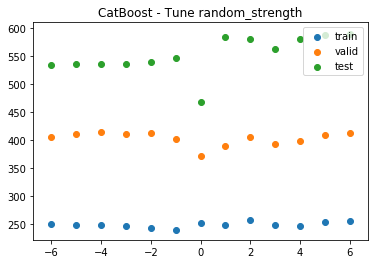

In [29]:
RMSE_train_list = []
RMSE_valid_list = []
RMSE_test_list = []

n_list = list(range(-6,7,1))

for n in n_list:
    print(n)    
    CB_model = CatBoostRegressor(learning_rate=0.1, 
                                 max_depth=8, 
                                 n_estimators=1000, 
                                 l2_leaf_reg=6,
                                 random_strength=n,
                                 bagging_temperature=1,
                                 task_type=CB_task)
    
    CB_model.fit(X_train, y_train, verbose=0)
    RMSE_train = math.sqrt(mean_squared_error(y_train, CB_model.predict(X_train)))
    RMSE_valid = math.sqrt(mean_squared_error(y_valid, CB_model.predict(X_valid)))
    RMSE_test = math.sqrt(mean_squared_error(y_test, CB_model.predict(X_test)))
    
    RMSE_train_list.append(RMSE_train)
    RMSE_valid_list.append(RMSE_valid)
    RMSE_test_list.append(RMSE_test)
    
plt.scatter(n_list, RMSE_train_list, label='train')
plt.scatter(n_list, RMSE_valid_list, label='valid')
plt.scatter(n_list, RMSE_test_list, label='test')
plt.title('CatBoost - Tune random_strength')
plt.legend();

print()
print()
print('Minimum RMSE for Validation, optimal random_strength: ', n_list[np.argmin(RMSE_valid_list)])
print('Minimum RMSE for Testing, optimal random_strength: ',n_list[np.argmin(RMSE_test_list)])

##### CatBoost - Tune Bagging Temperature

0
10
20
30
40
50
60
70
80
90


Minimum RMSE for Validation, optimal bagging_temperature:  40
Minimum RMSE for Testing, optimal bagging_temperature:  40


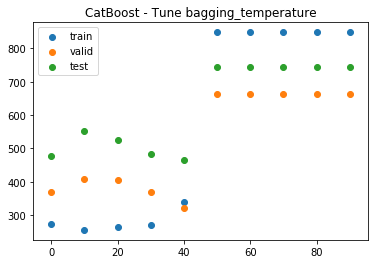

In [31]:
RMSE_train_list = []
RMSE_valid_list = []
RMSE_test_list = []

n_list = range(0,100,10)

for n in n_list:
    print(n)    
    CB_model = CatBoostRegressor(learning_rate=0.1, 
                                 max_depth=8, 
                                 n_estimators=1000, 
                                 l2_leaf_reg=6,
                                 random_strength=0,
                                 bagging_temperature=n,
                                 task_type=CB_task)
    
    CB_model.fit(X_train, y_train, verbose=0)
    RMSE_train = math.sqrt(mean_squared_error(y_train, CB_model.predict(X_train)))
    RMSE_valid = math.sqrt(mean_squared_error(y_valid, CB_model.predict(X_valid)))
    RMSE_test = math.sqrt(mean_squared_error(y_test, CB_model.predict(X_test)))
    
    RMSE_train_list.append(RMSE_train)
    RMSE_valid_list.append(RMSE_valid)
    RMSE_test_list.append(RMSE_test)
    
plt.scatter(n_list, RMSE_train_list, label='train')
plt.scatter(n_list, RMSE_valid_list, label='valid')
plt.scatter(n_list, RMSE_test_list, label='test')
plt.title('CatBoost - Tune bagging_temperature')
plt.legend();

print()
print()
print('Minimum RMSE for Validation, optimal bagging_temperature: ', n_list[np.argmin(RMSE_valid_list)])
print('Minimum RMSE for Testing, optimal bagging_temperature: ',n_list[np.argmin(RMSE_test_list)])

##### CatBoost - Tune Learning Rate

0.01
0.05
0.1
0.5
1


Minimum RMSE for Validation, optimal learning_rate:  0.05
Minimum RMSE for Testing, optimal learning_rate:  0.01


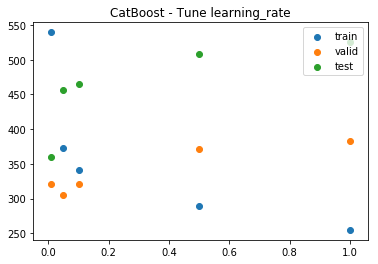

In [33]:
RMSE_train_list = []
RMSE_valid_list = []
RMSE_test_list = []

n_list = [0.01, 0.05, 0.1,0.5, 1]

for n in n_list:
    print(n)    
    CB_model = CatBoostRegressor(learning_rate=n, 
                                 max_depth=8, 
                                 n_estimators=1000, 
                                 l2_leaf_reg=6,
                                 random_strength=0,
                                 bagging_temperature=40,
                                 task_type=CB_task)
    
    CB_model.fit(X_train, y_train, verbose=0)
    RMSE_train = math.sqrt(mean_squared_error(y_train, CB_model.predict(X_train)))
    RMSE_valid = math.sqrt(mean_squared_error(y_valid, CB_model.predict(X_valid)))
    RMSE_test = math.sqrt(mean_squared_error(y_test, CB_model.predict(X_test)))
    
    RMSE_train_list.append(RMSE_train)
    RMSE_valid_list.append(RMSE_valid)
    RMSE_test_list.append(RMSE_test)
    
plt.scatter(n_list, RMSE_train_list, label='train')
plt.scatter(n_list, RMSE_valid_list, label='valid')
plt.scatter(n_list, RMSE_test_list, label='test')
plt.title('CatBoost - Tune learning_rate')
plt.legend();

print()
print()
print('Minimum RMSE for Validation, optimal learning_rate: ', n_list[np.argmin(RMSE_valid_list)])
print('Minimum RMSE for Testing, optimal learning_rate: ',n_list[np.argmin(RMSE_test_list)])

##### CatBoost - Tune Estimator

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


Minimum RMSE for Validation, optimal n_estimators:  500
Minimum RMSE for Testing, optimal n_estimators:  100


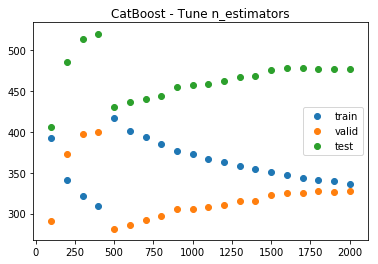

In [35]:
RMSE_train_list = []
RMSE_valid_list = []
RMSE_test_list = []

n_list = range(100,2100,100)

for n in n_list:
    print(n)    
    CB_model = CatBoostRegressor(learning_rate=0.05, 
                                 max_depth=8, 
                                 n_estimators=n, 
                                 l2_leaf_reg=6,
                                 random_strength=0,
                                 bagging_temperature=40,
                                 task_type=CB_task)
    
    CB_model.fit(X_train, y_train, verbose=0)
    RMSE_train = math.sqrt(mean_squared_error(y_train, CB_model.predict(X_train)))
    RMSE_valid = math.sqrt(mean_squared_error(y_valid, CB_model.predict(X_valid)))
    RMSE_test = math.sqrt(mean_squared_error(y_test, CB_model.predict(X_test)))
    
    RMSE_train_list.append(RMSE_train)
    RMSE_valid_list.append(RMSE_valid)
    RMSE_test_list.append(RMSE_test)
    
plt.scatter(n_list, RMSE_train_list, label='train')
plt.scatter(n_list, RMSE_valid_list, label='valid')
plt.scatter(n_list, RMSE_test_list, label='test')
plt.title('CatBoost - Tune n_estimators')
plt.legend();

print()
print()
print('Minimum RMSE for Validation, optimal n_estimators: ', n_list[np.argmin(RMSE_valid_list)])
print('Minimum RMSE for Testing, optimal n_estimators: ',n_list[np.argmin(RMSE_test_list)])

##### CatBoost - Best Model Parameters

In [ ]:
CB_model = CatBoostRegressor(learning_rate=0.05, 
                             max_depth=8, 
                             n_estimators=500, 
                             l2_leaf_reg=4,
                             random_strength=0,
                             bagging_temperature=40,
                             task_type=CB_task)

## Appendice 2 - Individual Model Ouputs

#### Linear Regression

In [109]:
from statsmodels.regression import linear_model

lin_reg_model_sm = linear_model.OLS(y_train, X_train_c).fit()
lin_reg_model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     230.7
Date:                Thu, 05 Sep 2019   Prob (F-statistic):          7.51e-276
Time:                        20:12:41   Log-Likelihood:                -5418.3
No. Observations:                 730   AIC:                         1.087e+04
Df Residuals:                     712   BIC:                         1.096e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    89.3768     27.679      3.229      0.001      35.034     143.719
AVG_TEMP_MEAN           160.2056     45.364      3.532      0.000      71.142     249.269
SUM_PRECIP_TOTAL        -30.2747      2.159    -14.022      0.000     -34.513     -26.036
MAX_TEMP_MEAN            51.9079     24.315      2.135      0.033       4.170      99.646
MIN_TEMP_MEAN          -123.3256     23.920     -5.156      0.000    -170.288     -76.364
HOLIDAY                  17.5973     50.072      0.351      0.725     -80.710     115.904
NOT_HOLIDAY              71.7795     37.284      1.925      0.055      -1.421     144.980
Weekday                 104.2826     19.296      5.404      0.000      66.399     142.166
Weekend                 -14.9057     17.968     -0.830      0.407     -50.183      20.371
day_of_week_Friday       50.6270     36.198      1.399      0.162     -20.440     121.694
day_of_week_Monday      -35.5753     36.891     -0.964      0.335    -108.003      36.852
day_of_week_Saturday     72.4028     29.772      2.432      0.015      13.952     130.854
day_of_week_Sunday      -87.3085     29.813     -2.929      0.004    -145.840     -28.777
day_of_week_Thursday     53.8860     36.646      1.470      0.142     -18.062     125.834
day_of_week_Tuesday      30.6977     36.436      0.843      0.400     -40.837     102.233
day_of_week_Wednesday     4.6472     36.382      0.128      0.898     -66.782      76.076
SEASON_Autumn             7.9719     57.795      0.138      0.890    -105.497     121.441
SEASON_Spring          -141.6792     53.857     -2.631      0.009    -247.417     -35.942
SEASON_Summer           331.6684     62.950      5.269      0.000     208.079     455.258
SEASON_Winter          -108.5842     55.525     -1.956      0.051    -217.597       0.428
QUARTER_1              -111.2705     54.350     -2.047      0.041    -217.976      -4.565
QUARTER_2               100.4451     57.371      1.751      0.080     -12.191     213.081
QUARTER_3               104.8765     60.937      1.721      0.086     -14.762     224.515
QUARTER_4                -4.6743     57.580     -0.081      0.935    -117.720     108.372
==============================================================================
Omnibus:                        2.327   Durbin-Watson:                   0.876
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                2.309
Skew:                           0.138   Prob(JB):                        0.315
Kurtosis:                       2.983   Cond. No.                     5.21e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.34e-30. This might indicate that there are


Training - RMSE  Validation - RMSE  Test - RMSE  Training - R2  Valid - R2  \
0       404.757259         421.274793   558.745766       0.846386   -1.003925   

   Test - R2  
0   0.175153

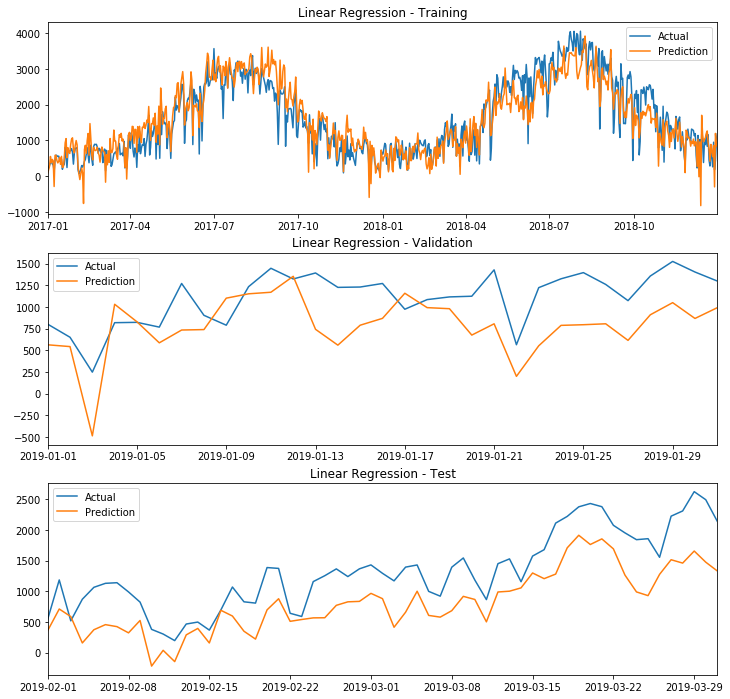

In [110]:
lin_y_pred_list = custom_predict(lin_reg_model_sm, X_train_c, X_valid_c, X_test_c, y_scaler=None)
lin_score = custom_model_score(lin_y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(lin_score))
custom_plot_package('Linear Regression', lin_y_pred_list, y_train, y_valid, y_test)

#### Random Forest

Note: I did not tune this model.

In [111]:
from sklearn.ensemble import RandomForestRegressor

RF_model = RandomForestRegressor(n_estimators=50, max_depth=10, oob_score=False, n_jobs=-1)
RF_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Training - RMSE  Validation - RMSE  Test - RMSE  Training - R2  Valid - R2  \
0       182.186458          398.31014   486.551616       0.968878   -0.791403   

   Test - R2  
0   0.374535

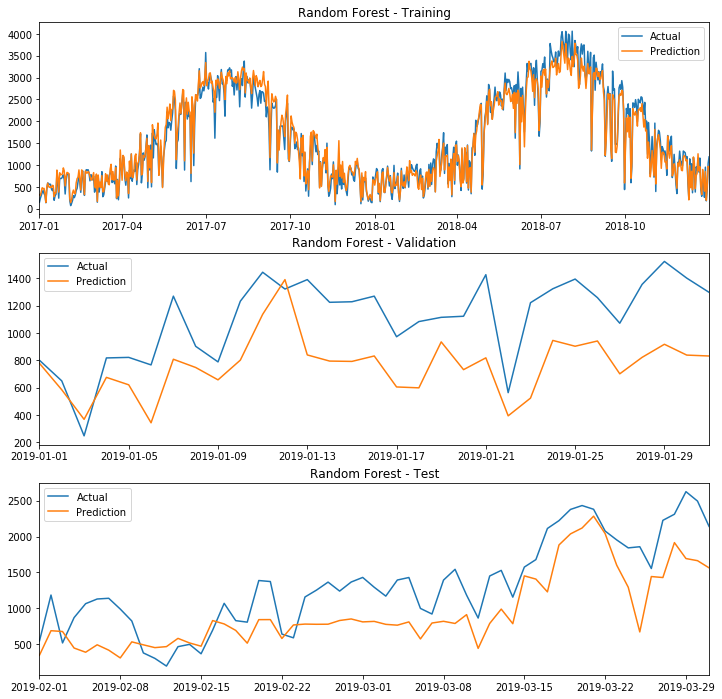

In [112]:
RF_y_pred_list = custom_predict(RF_model, X_train, X_valid, X_test, y_scaler=None)
RF_score = custom_model_score(RF_y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(RF_score))
custom_plot_package('Random Forest', RF_y_pred_list, y_train, y_valid, y_test)

#### XGBoost

In [113]:
from xgboost import XGBRegressor

XGB_model = XGBRegressor(learning_rate=0.05, max_depth=4, 
                         n_estimators=600, gamma=0, 
                         subsample=0.8, colsample_bytree=0.6,
                         scale_pos_weight=1, min_child_weight=1,
                         reg_alpha=1)
XGB_model.fit(X_train, y_train)

[20:12:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1)

Training - RMSE  Validation - RMSE  Test - RMSE  Training - R2  Valid - R2  \
0       137.322997         367.306895   493.178673       0.982318   -0.523381   

   Test - R2  
0   0.357381

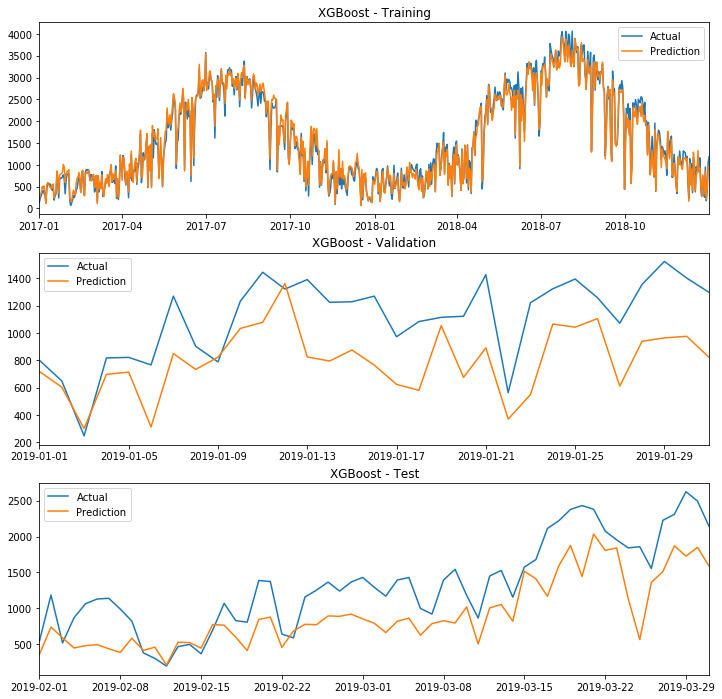

In [114]:
XGB_y_pred_list = custom_predict(XGB_model, X_train, X_valid, X_test, y_scaler=None)
XGB_score = custom_model_score(XGB_y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(XGB_score))
custom_plot_package('XGBoost', XGB_y_pred_list, y_train, y_valid, y_test)

#### CatBoost

In [115]:
from catboost import CatBoostRegressor

CB_model = CatBoostRegressor(learning_rate=0.05, 
                             max_depth=8, 
                             n_estimators=500, 
                             l2_leaf_reg=4,
                             random_strength=0,
                             bagging_temperature=40,
                             task_type=CB_task)

CB_model.fit(X_train, y_train, verbose=0)

Training - RMSE  Validation - RMSE  Test - RMSE  Training - R2  Valid - R2  \
0       409.909467          279.20671   445.517182       0.842451    0.119758   

   Test - R2  
0   0.475586

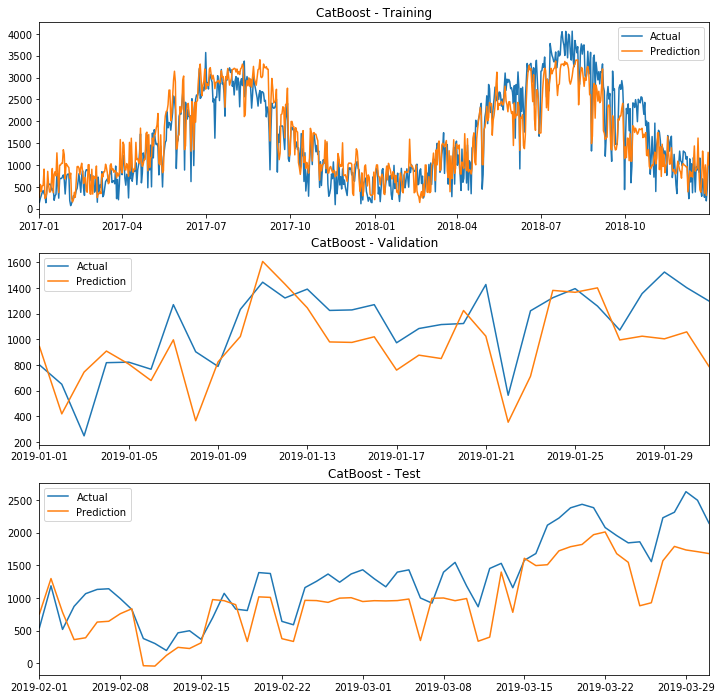

In [116]:
CB_y_pred_list = custom_predict(CB_model, X_train, X_valid, X_test, y_scaler=None)
CB_score = custom_model_score(CB_y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(CB_score))
custom_plot_package('CatBoost', CB_y_pred_list, y_train, y_valid, y_test)

#### Neural Network

In [117]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, BatchNormalization

In [118]:
from sklearn.preprocessing import MinMaxScaler

x_scaler_NN = MinMaxScaler()
X_train_NN_scaled = x_scaler_NN.fit_transform(X_train)
X_valid_NN_scaled = x_scaler_NN.transform(X_valid)
X_test_NN_scaled = x_scaler_NN.transform(X_test)

y_scaler_NN = MinMaxScaler()
y_train_NN_scaled = y_scaler_NN.fit_transform(y_train.values.reshape(-1,1))
y_valid_NN_scaled = y_scaler_NN.transform(y_valid.values.reshape(-1,1))
y_test_NN_scaled = y_scaler_NN.transform(y_test.values.reshape(-1,1))

In [119]:
NN_model = Sequential()
NN_model.add(Dense(128, input_dim=X_train_NN_scaled.shape[1], activation='relu'))
NN_model.add(Dense(25, activation='relu'))
NN_model.add(Dense(1, activation='relu'))
NN_model.summary()

NN_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

history = NN_model.fit(X_train_NN_scaled, y_train_NN_scaled, epochs=100, verbose=0, batch_size=32, 
                       validation_data=(X_valid_NN_scaled, y_valid_NN_scaled), shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               3072      
_________________________________________________________________
dense_8 (Dense)              (None, 25)                3225      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 26        
Total params: 6,323
Trainable params: 6,323
Non-trainable params: 0
_________________________________________________________________


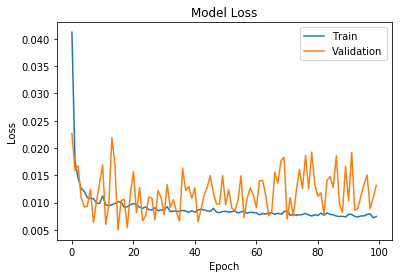

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show();

Training - RMSE  Validation - RMSE  Test - RMSE  Training - R2  Valid - R2  \
0       332.754076          457.63942   590.782747       0.896179   -1.364816   

   Test - R2  
0   0.077852

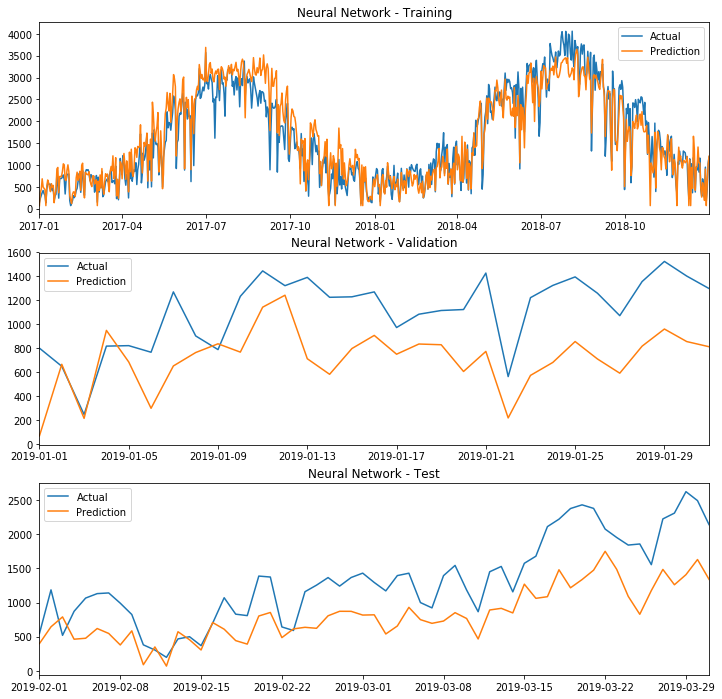

In [121]:
NN_y_pred_list = custom_predict(NN_model, X_train_NN_scaled, X_valid_NN_scaled, X_test_NN_scaled, y_scaler_NN)
NN_score = custom_model_score(NN_y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(NN_score))
custom_plot_package('Neural Network', NN_y_pred_list, y_train, y_valid, y_test)

## Appendice 3 - Backtesting Outputs

0
[20:55:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


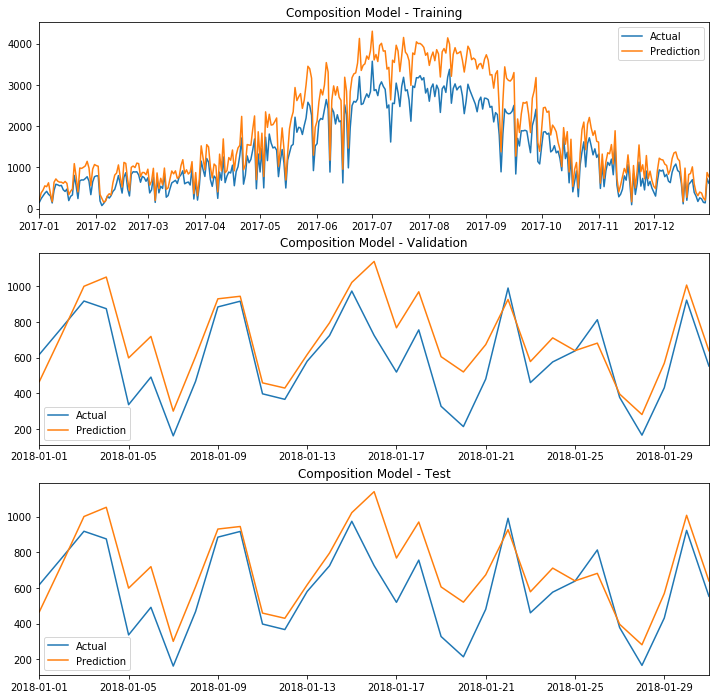

1
[20:55:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


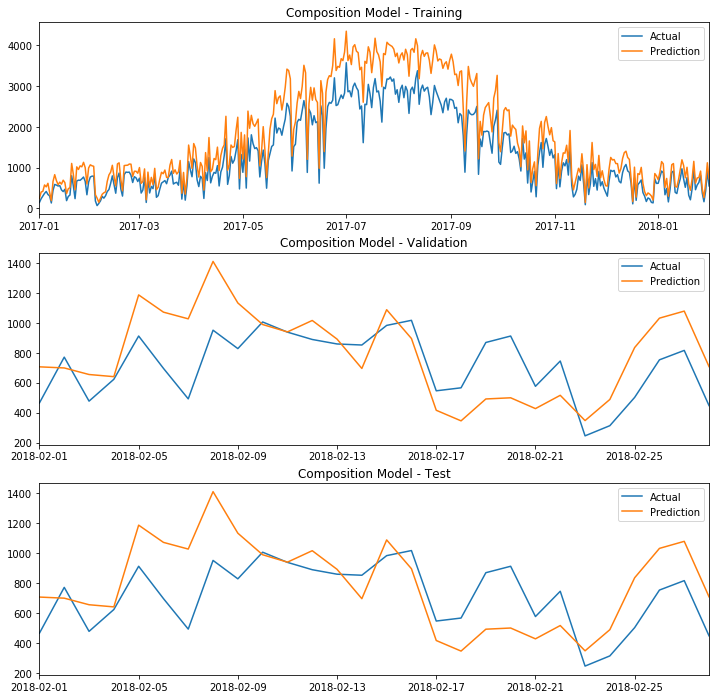

2
[20:55:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


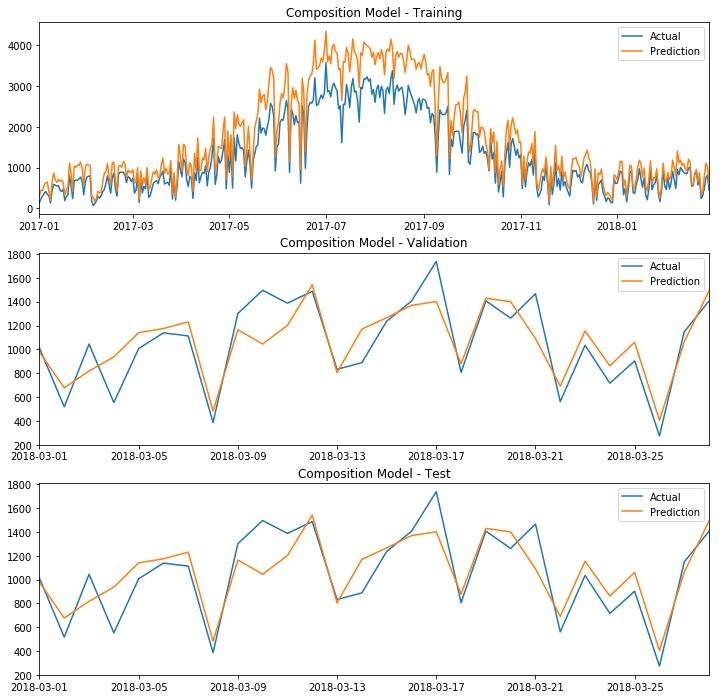

3
[20:56:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


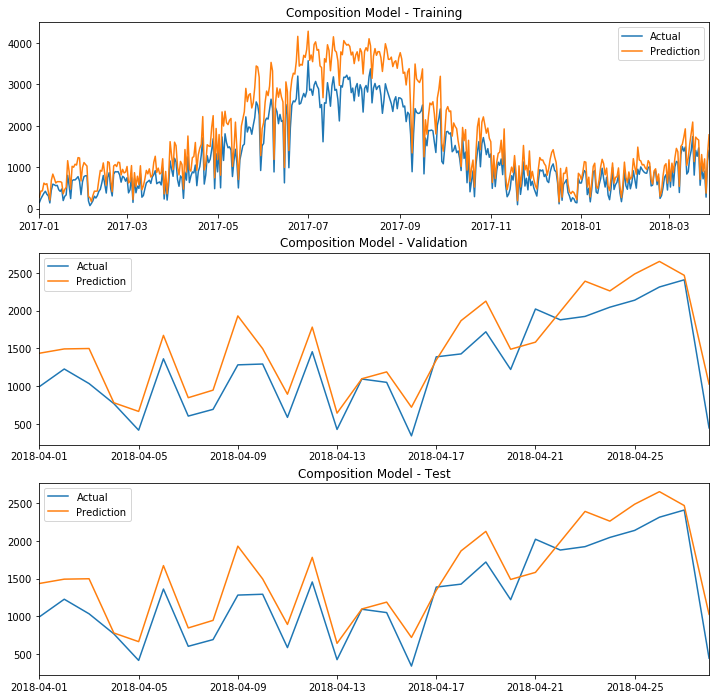

4
[20:56:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


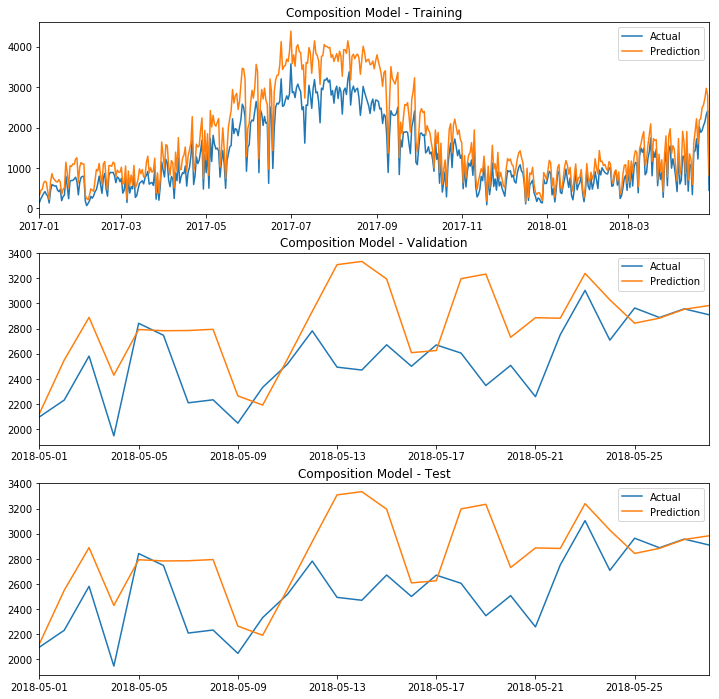

5
[20:56:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


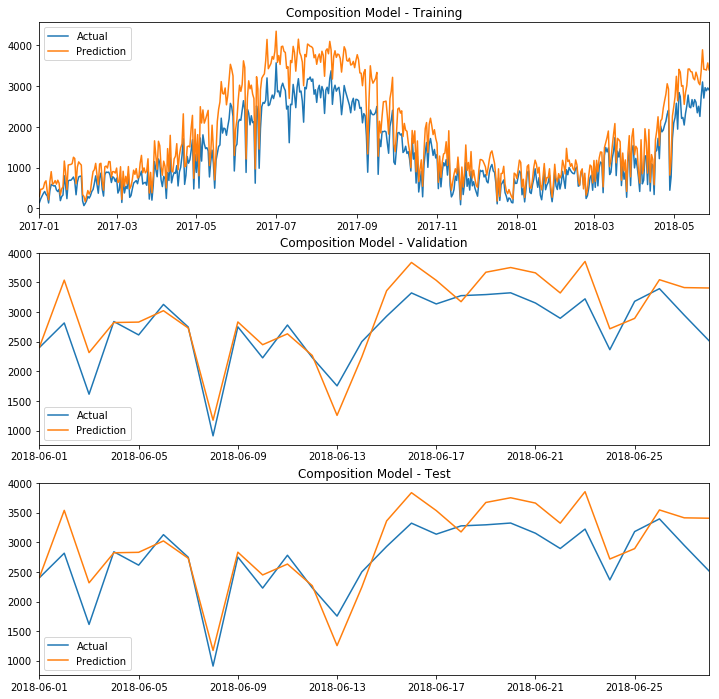

6
[20:56:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


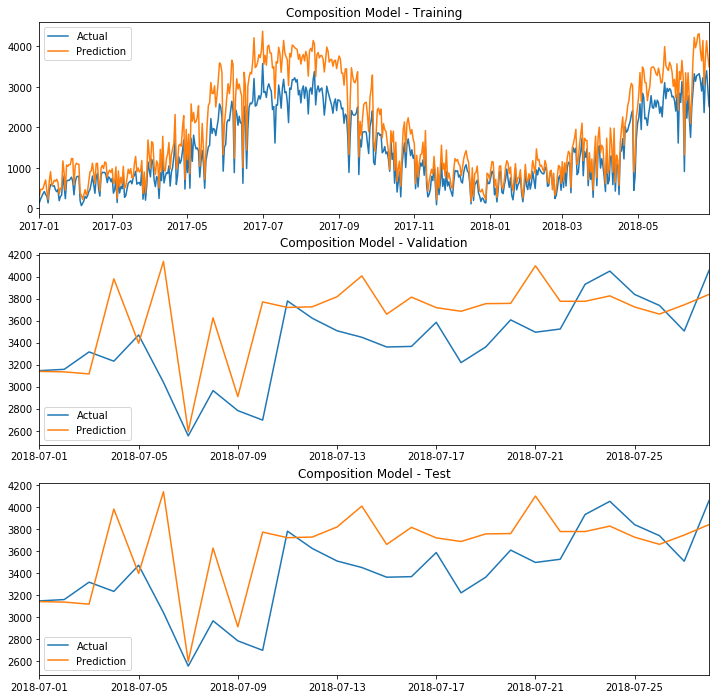

7
[20:57:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


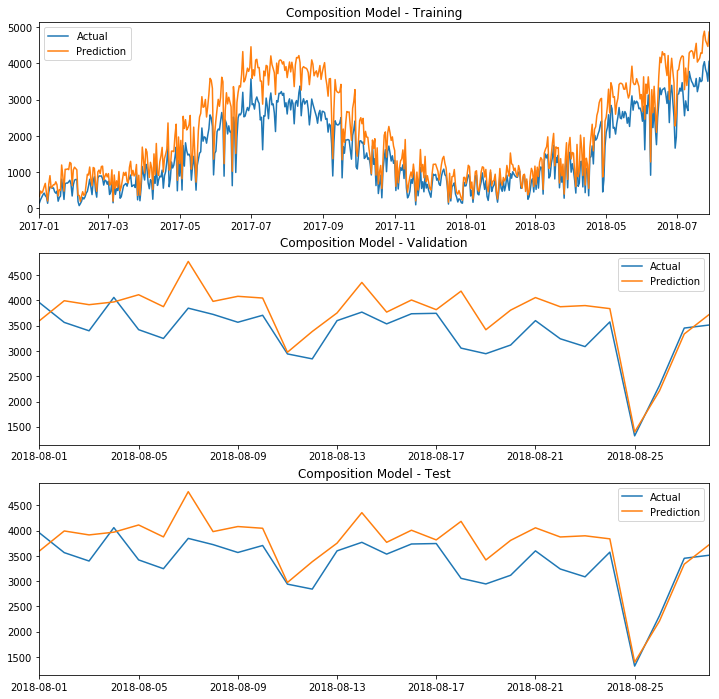

8
[20:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


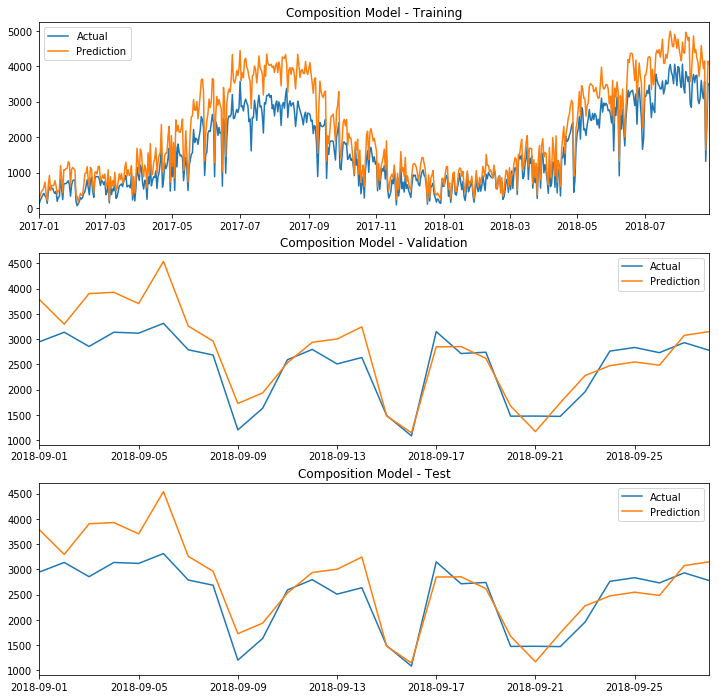

9
[20:57:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


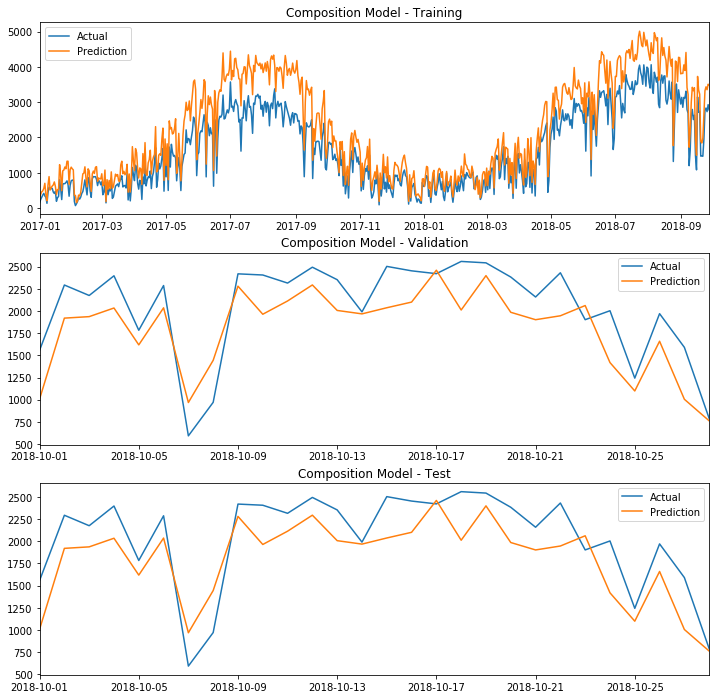

10
[20:57:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


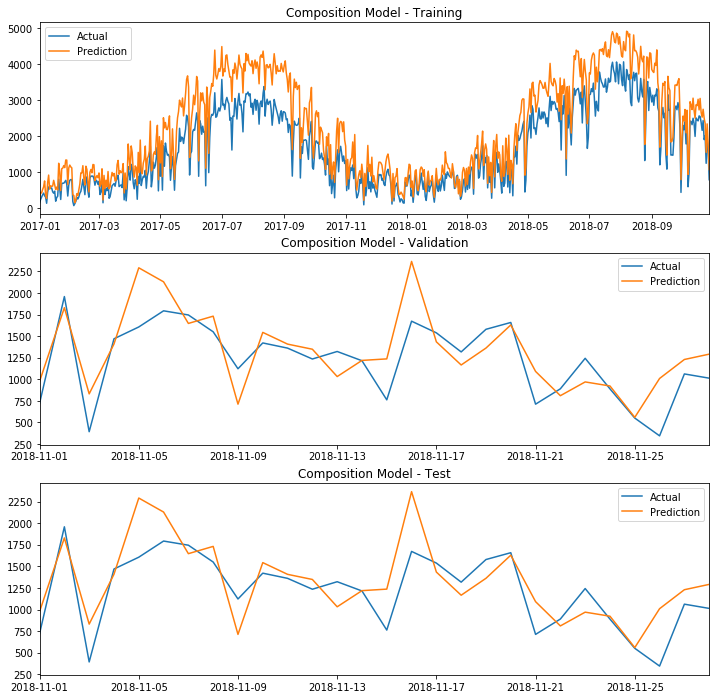

11
[20:58:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


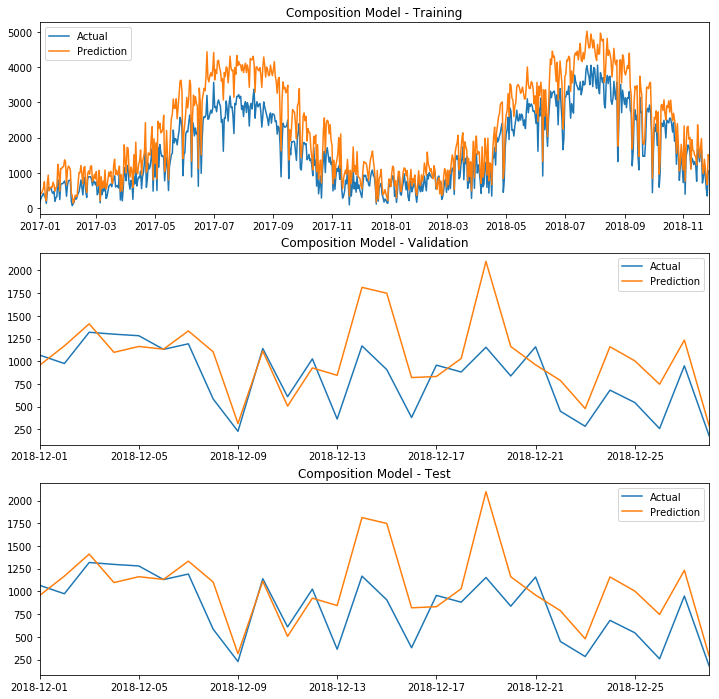

12
[20:58:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


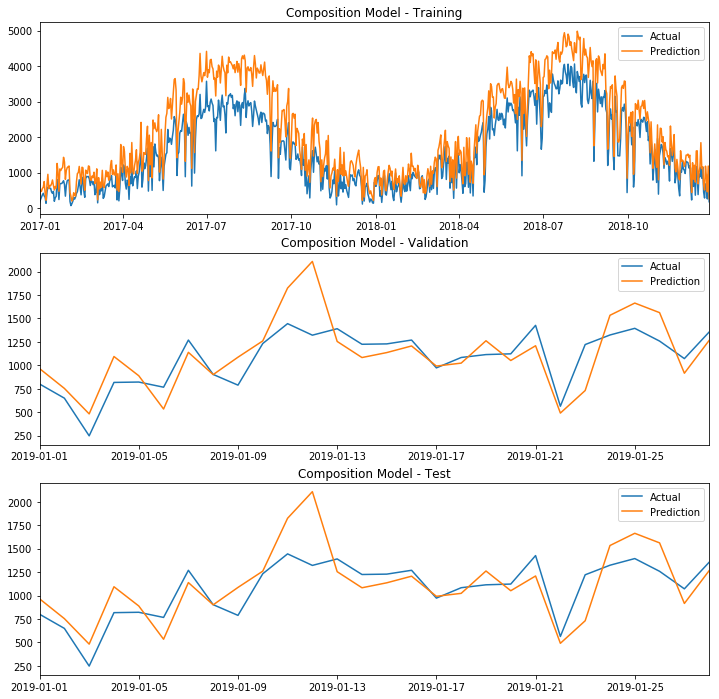

13
[20:58:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


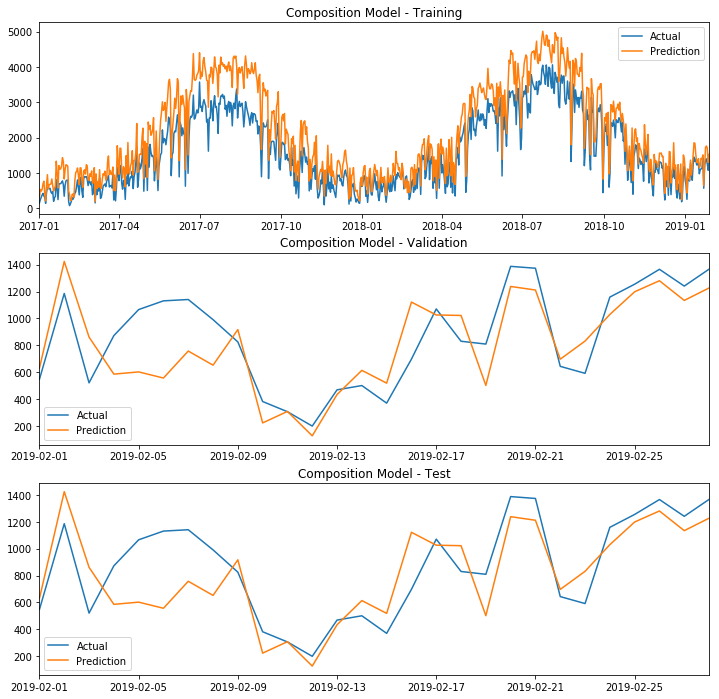

14
[20:58:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


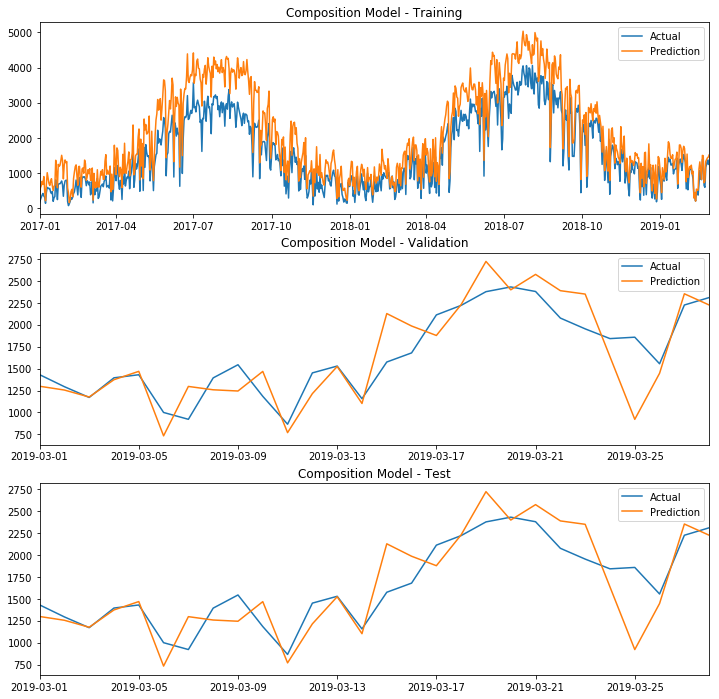

In [139]:
from dateutil.relativedelta import *

output_score = []

start_date = datetime.date(2018, 1, 1)
end_date = datetime.date(2017, 12, 31)

for i in range(0,15):
    print(i)
    date_range_train = pd.date_range(start=datetime.date(2017, 1, 1), end=end_date, freq='D')
    date_range_valid = pd.date_range(start=start_date, end=(end_date + relativedelta(months=+1)), freq='D')
    date_range_test = pd.date_range(start=start_date, end=(end_date + relativedelta(months=+1)), freq='D')
                         
    start_date += relativedelta(months=+1)
    end_date += relativedelta(months=+1)
    
    X_onehot = pd.get_dummies(X)
    X_train, X_valid,  X_test = custom_tvt_split(X_onehot, date_range_train, date_range_valid, date_range_test)
    
    y_train, y_valid,  y_test = custom_tvt_split(y, date_range_train, date_range_valid, date_range_test)
    
    import statsmodels.api as sm
    X_onehot_c = sm.add_constant(X_onehot)
    X_train_c, X_valid_c,  X_test_c = custom_tvt_split(X_onehot_c, date_range_train, date_range_valid, date_range_test)
    
    
    #=== Linear Regression
    lin_reg_model_sm = linear_model.OLS(y_train, X_train_c).fit()
    lin_y_pred_list = custom_predict(lin_reg_model_sm, X_train_c, X_valid_c, X_test_c)
    lin_score = custom_model_score(lin_y_pred_list, y_train, y_valid, y_test)
    
    #=== Random Forest
    RF_model.fit(X_train, y_train)
    RF_y_pred_list = custom_predict(RF_model, X_train, X_valid, X_test)
    RF_score = custom_model_score(RF_y_pred_list, y_train, y_valid, y_test)
    
    #=== XGBoost
    XGB_model.fit(X_train, y_train)
    XGB_y_pred_list = custom_predict(XGB_model, X_train, X_valid, X_test)
    XGB_score = custom_model_score(XGB_y_pred_list, y_train, y_valid, y_test)
   
    #=== CatBoost
    CB_model.fit(X_train, y_train, verbose=False)
    CB_y_pred_list = custom_predict(CB_model, X_train, X_valid, X_test)
    CB_score = custom_model_score(CB_y_pred_list, y_train, y_valid, y_test)
    
    #=== Neural Network
    
    from sklearn.preprocessing import MinMaxScaler

    x_scaler_NN = MinMaxScaler()
    X_train_NN_scaled = x_scaler_NN.fit_transform(X_train)
    X_valid_NN_scaled = x_scaler_NN.transform(X_valid)
    X_test_NN_scaled = x_scaler_NN.transform(X_test)

    y_scaler_NN = MinMaxScaler()
    y_train_NN_scaled = y_scaler_NN.fit_transform(y_train.values.reshape(-1,1))
    y_valid_NN_scaled = y_scaler_NN.transform(y_valid.values.reshape(-1,1))
    y_test_NN_scaled = y_scaler_NN.transform(y_test.values.reshape(-1,1))
    
    history = NN_model.fit(X_train_NN_scaled, y_train_NN_scaled, epochs=100, verbose=0, batch_size=32, 
                       validation_data=(X_valid_NN_scaled, y_valid_NN_scaled), shuffle=True)

    NN_y_pred_list = custom_predict(NN_model, X_train_NN_scaled, X_valid_NN_scaled, X_test_NN_scaled, y_scaler_NN)
    NN_score = custom_model_score(NN_y_pred_list, y_train, y_valid, y_test)

    #===
    
    best_model_y_pred_list = predict_composition_model(index_list=[X_train.index, X_valid.index, X_test.index])
    best_model_score = custom_model_score(best_model_y_pred_list, y_train, y_valid, y_test)
    
    custom_plot_package('Composition Model', best_model_y_pred_list, y_train, y_valid, y_test)
    
    scores = custom_score_display([best_model_score, lin_score, RF_score, XGB_score, CB_score, NN_score], 
                     index=['Composition Model', 'Linear Regression', 'Random Forest', 'XGBoost', 'CatBoost', 'Neural Network']).iloc[:,2]

    output_score.append(scores)